In [1]:
import pandas as pd
import urllib
import numpy as np
import sklearn.linear_model as lm
import matplotlib.pyplot as plt

from pylab import rcParams
rcParams['figure.figsize'] = 15, 4

In [2]:
import nltk
nltk.download()
# Descargar la coleccion "popular" usando el gestor de NLTK

showing info https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/index.xml


True

# <center>Tarea 2 Máquinas de Aprendizaje</center>

<center>
Patricio Horth M.<br>
Víctor Zúñiga M.<br>

2 de Noviembre de 2017
</center>



# Introducción

Este trabajo tratará sobre la generación de modelos de clasificación para tres problemas distintos, utilizando los siguientes métodos lineales: PCA (*Principal Component Analysis*), LDA (*Linear Discriminant Analysis*), QDA (*Quadratic Discriminant Analysis*), k-NN (*k Nearest Neighbours*), *Naive Bayes*, SVMs (*Support Vector Machines*) y *Logistic Regression*. Se harán comparaciones entre los modelos generados, los parámetros de entrada posibles y las aplicaciones que más tienen sentido para cada uno.

# 1. Identificación de sonidos fonéticos

## a) Ingreso de los datos

Se comenzará con la carga de los conjuntos de entrenamiento y de prueba de sonidos fonéticos del inglés británico.

In [2]:
train_data_url = "https://statweb.stanford.edu/~hastie/ElemStatLearn/datasets/vowel.train"
test_data_url = "https://statweb.stanford.edu/~hastie/ElemStatLearn/datasets/vowel.test"
train_data_f = urllib.request.urlretrieve(train_data_url, "train_data.csv")
test_data_f = urllib.request.urlretrieve(test_data_url, "test_data.csv")
train_df = pd.DataFrame.from_csv('train_data.csv',header=0,index_col=0)
test_df = pd.DataFrame.from_csv('test_data.csv',header=0,index_col=0)

In [3]:
train_df.head()

,y,x.1,x.2,x.3,x.4,x.5,x.6,x.7,x.8,x.9,x.10
row.names,,,,,,,,,,,
1,1,-3.639,0.418,-0.670,1.779,-0.168,1.627,-0.388,0.529,-0.874,-0.814
2,2,-3.327,0.496,-0.694,1.365,-0.265,1.933,-0.363,0.510,-0.621,-0.488
3,3,-2.120,0.894,-1.576,0.147,-0.707,1.559,-0.579,0.676,-0.809,-0.049
4,4,-2.287,1.809,-1.498,1.012,-1.053,1.060,-0.567,0.235,-0.091,-0.795
5,5,-2.598,1.938,-0.846,1.062,-1.633,0.764,0.394,-0.150,0.277,-0.396


In [4]:
test_df.tail()

,y,x.1,x.2,x.3,x.4,x.5,x.6,x.7,x.8,x.9,x.10
row.names,,,,,,,,,,,
458,7,-3.239,3.083,-1.427,-0.202,-0.282,1.421,0.576,0.068,-0.914,0.147
459,8,-3.753,3.605,-0.899,-0.747,-0.401,1.765,0.620,0.754,-0.835,-0.301
460,9,-3.980,2.459,0.068,0.023,0.237,1.029,-0.189,0.521,-0.773,-0.500
461,10,-4.264,2.925,0.065,0.794,0.323,0.515,-1.282,-0.140,-0.863,-0.390
462,11,-3.291,2.324,-0.679,0.285,0.441,0.557,-0.227,0.115,-1.046,0.697


In [5]:
print("El conjunto de entrenamiento tiene", train_df.shape[0], "registros")

El conjunto de entrenamiento tiene 528 registros


In [6]:
print("El conjunto de entrenamiento tiene", test_df.shape[0], "registros")

El conjunto de entrenamiento tiene 462 registros


Podemos ver que este *dataset* sólo indica 10 características para cada dato. Cada valor en las características es un número real, y las salidas son números enteros. Es necesario revisar cómo se distribuyen estas salidas.

In [7]:
from collections import Counter
Counter(train_df.y)

Counter({1: 48,
         2: 48,
         3: 48,
         4: 48,
         5: 48,
         6: 48,
         7: 48,
         8: 48,
         9: 48,
         10: 48,
         11: 48})

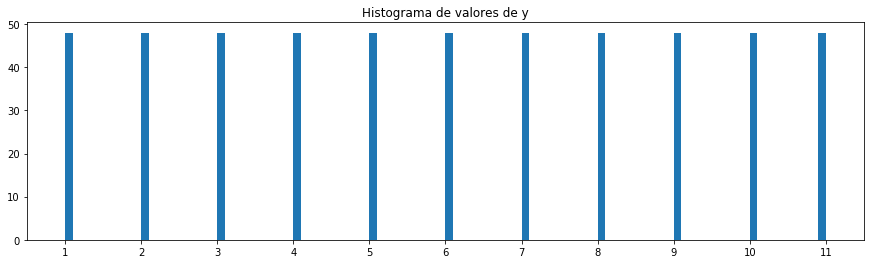

In [8]:
from matplotlib.pylab import hist, show
from pylab import rcParams

plt.title("Histograma de valores de y")
plt.xticks(range(1,12))
plt.hist(train_df.y,bins=100)
plt.show()

In [9]:
from collections import Counter
Counter(train_df.y)

Counter({1: 48,
         2: 48,
         3: 48,
         4: 48,
         5: 48,
         6: 48,
         7: 48,
         8: 48,
         9: 48,
         10: 48,
         11: 48})

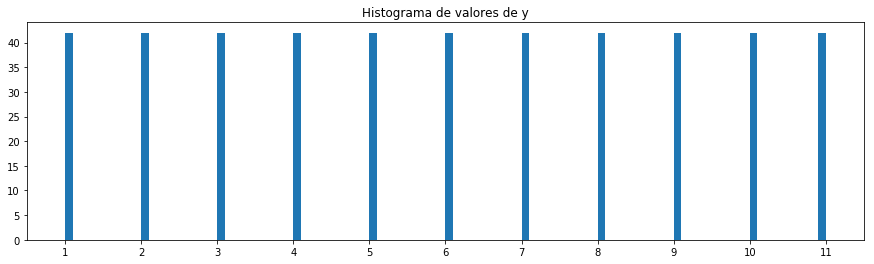

In [10]:
from matplotlib.pylab import hist, show
from pylab import rcParams

plt.title("Histograma de valores de y")
plt.xticks(range(1,12))
plt.hist(test_df.y,bins=100)
plt.show()

En ambos datasets (entrenamiento y prueba) las salidas son parte del conjunto de números enteros $[1,11]$, y se tiene un número igual de casos para cada posible salida, por lo tanto, podemos decir que **las clases de los *datasets* están bien balanceadas**.

## b) Tranformación de los datos: Normalización

Antes de aplicar técnicas de reducción de dimensionalidad, los datos de cada característica se estandarizarán utilizando **StandardScaler**, la cual transforma los valores restándole el promedio y dividiendo por la desviación estándar (de cada variable o característica). Esto hace que los datos de cada variable tengan una media o esperanza centrada en 0, y varianzas bajo el mismo orden de magnitud.

In [11]:
from sklearn.preprocessing import StandardScaler
X = train_df.loc[:,'x.1':'x.10'].values
y = train_df.loc[:,'y'].values
Scaler = StandardScaler().fit(X)
X_std = Scaler.transform(X)

## c), d) y e) Tranformación de los datos: Reducción a 2 dimensiones mediante PCA y LDA

A continuación, se utilizará **PCA** (*Principal Component Analysis*) para proyectar cada uno de los datos de entrenamiento en tan sólo **dos dimensiones** (que para PCA, serán los vectores con direcciones de mayor varianza), y luego se hará un coloreo de cada uno de los datos en esta proyección según la clase *target* a la que pertenecen (o sea, entre 1 y 11). Se dice que PCA es un clasificador **no supervisado**, ya que no requiere que los datos de entrenamiento estén ya clasificados (con *labels*).

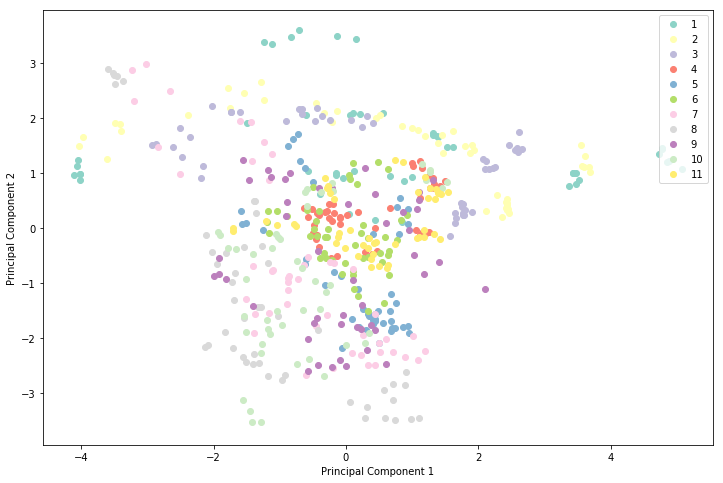

In [12]:
from sklearn.decomposition import PCA
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
sklearn_pca = PCA(n_components=2)
Xred_pca = sklearn_pca.fit_transform(X_std)
cmap = plt.cm.get_cmap("Set3")
mclasses=(1,2,3,4,5,6,7,8,9,10,11)
mcolors = [cmap(i) for i in np.linspace(0,1,11)]
plt.figure(figsize=(12, 8))
for lab, col in zip(mclasses,mcolors):
    plt.scatter(Xred_pca[y==lab, 0],Xred_pca[y==lab, 1],label=lab,c=col, marker='o')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
leg = plt.legend(loc='upper right', fancybox=True)
plt.show()

Podemos ver que PCA logra proyectar los datos de entrenamiento en las dos dimensiones, pero al ver las *labels* o las clases a las que pertenecen, nos damos cuenta que no se produce una buena separación de éstas. Por lo tanto, si más adelante queremos hacer un clasificador con estos datos transformados, se **nos será muy difícil obtener buenos resultados**.

Ahora se realizará el mismo ejercicio, pero utilizando **LDA** (*Linear Discriminant Analysis*). Este método se basa a grandes rasgos a encontrar el hiperplano (o subespacios con frontera de decisión lineal, en casos de más de 2 clases) que separa de mejor manera a las clases existentes. Utiliza como supuesto que los datos pertencientes a cada clase tienen una distribución normal, y que la covarianza entre clases es siempre la misma (matrices de covarianza iguales). Se dice que es un clasificador **supervisado**, ya que utiliza los *labels* que identifican a los datos de entrenamiento en alguna clase (en este caso, los valores de $y$ para cada fila del *dataset*)

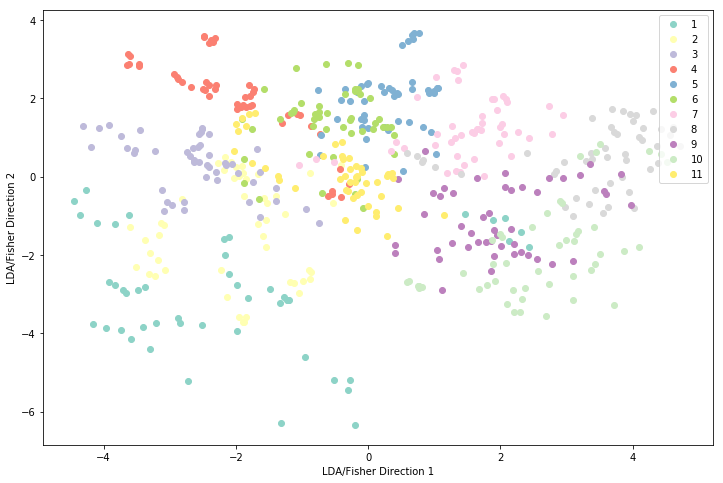

In [13]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
sklearn_lda = LDA(n_components=2)
Xred_lda = sklearn_lda.fit_transform(X_std,y)
cmap = plt.cm.get_cmap("Set3")
mclasses=(1,2,3,4,5,6,7,8,9,10,11)
mcolors = [cmap(i) for i in np.linspace(0,1,11)]
plt.figure(figsize=(12, 8))
for lab, col in zip(mclasses,mcolors):
    plt.scatter(Xred_lda[y==lab, 0],Xred_lda[y==lab, 1],label=lab,c=col)
plt.xlabel('LDA/Fisher Direction 1')
plt.ylabel('LDA/Fisher Direction 2')
leg = plt.legend(loc='upper right', fancybox=True)
plt.show()

Podemos ver que LDA logra separar las clases de mejor manera, y por lo tanto, utilizando sólo estas dos dimensiones podremos crear un clasificador que asigne nuevos datos de prueba en forma relativamente correcta. Vale mencionar que, a pesar de tener una major proyección que PCA, aún existen problemas con **outliers** y espacios donde las clases comparten elementos de prueba, por ejemplo, con el caso donde el espacio de las clases 8 y 9 tiene elementos de la clase 1.

## f) Clasificador aleatorio a-priori

A continuación se implementa un clasificador que simplemente elige una clase aleatoriamente, según la probabilidad de cada clase en el conjunto de entrenamiento. Citando el enunciado del problema: *"Por ejemplo, si la clase y = 0 ocurre
el 25% de las veces, el clasificador debe predecir esta clase para un determinado x con probabilidad
0.25, independiente de los atributos de x."*

In [15]:
from collections import Counter
Counter(y)

print(y.shape[0])
print(list(set(y)))

528
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]


Error de clasificador aleatorio a-priori es 0.9166666666666666


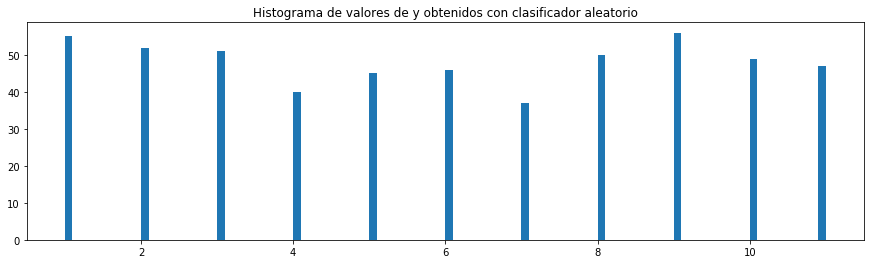

In [16]:
import random
from sklearn.metrics import accuracy_score as accuracy_score

def get_probabilities(y):
    sum = y.shape[0]
    y_set = list(set(y))
    y_probabilities = []
    for i in y_set:
        y_probabilities.append( (list(y).count(i))/sum )
    return y_probabilities


def random_classifier(X,y):
    y_probabilities = get_probabilities(y)
    y_pred = random.choices(list(set(y)), weights=y_probabilities, k=y.shape[0])
    return y_pred

#Error de clasificacion
def get_error(yhat, ytest):
    error_total = 0
    for i in range(1, len(yhat)):
        if yhat[i] != ytest[i]:
            error_total = error_total + 1
    return error_total / len(yhat)
y_random = random_classifier(X_std,y)

print("Error de clasificador aleatorio a-priori es", get_error(y_random, y))

plt.title("Histograma de valores de y obtenidos con clasificador aleatorio")
plt.hist(y_random,bins=100)
plt.show()

Vemos que claramente, al tener 11 clases posibles y datos de entrenamiento bien balanceados, **el clasificador aleatorio a-priori tiene un mal rendimiento**, que además es difícil de predecir.

## g) Clasificación sin reducción de dimensionalidad: LDA, QDA y k-Nearest Neighbours

Un trabajo común es utilizar PCA o LDA para la reducción de dimensionalidad de un conjunto de datos, para luego poder aplicar otro algoritmo y generar un clasificador. Sin embargo, nuestro conjunto de datos tiene sólo 10 características, por lo que es posible que no se necesite hacer reducción de dimensionalidad.

A continuación se utilizarán tres algoritmos para generar clasificadores:

* **LDA** (Linear Discriminant Analysis), el cual ya utilizamos anteriormente
* **QDA** (Quadratic Discriminant Analysis), el cual es una generalización de LDA que no asume que la covarianza entre clases es igual, y por lo tanto, requiere además estimar estas covarianzas. Sin embargo, es capaz de generar fronteras de decisión cuadráticas, que pueden tener un mejor desempeño que las de LDA.
* **KNN** (k-Nearest Neighbours) es un algoritmo de clasificación simple, que a cada nuevo dato de prueba le asigna la clase mayoritaria de los $k$ vecinos más cercanos en el espacio. Por lo tanto, la estructura de datos simplemente guarda los datos de entrenamiento y no se hace computación hasta que ocurre la clasificación.

El parámetro k para KNN será probado en el conjunto entero $k \in [1,..,50]$, y se utilizará el valor de k que tenga mejor desempeño con el conjunto de prueba.

Vale mencionar que el *score* o puntaje con que se evalúan estos clasificadores es simplemente el porcentaje de elementos del conjunto de prueba que fueron clasificados correctamente (siendo $0$ si ninguno fue bien clasificado, $1$ si todos fueron bien clasificados, $0.5$ si la mitad de los datos fueron bien clasificados, etc.)

-----LDA-----
Score with training set: 0.683712121212
Score with testing set: 0.443722943723
-----QDA-----
Score with training set: 0.988636363636
Score with testing set: 0.471861471861
-----KNN-----
Best score with training set: 1.0 , using k = 1
Best score with testing set: 0.519480519481 , using k = 7


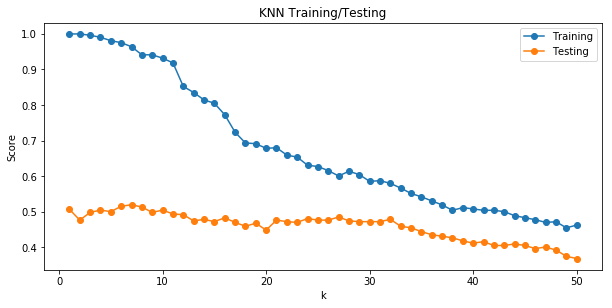

In [17]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt
Xtest = test_df.loc[:,'x.1':'x.10'].values
ytest = test_df.loc[:,'y'].values
X_std_test = Scaler.transform(Xtest)


lda_model = LDA()
lda_model.fit(X_std,y)
print("-----LDA-----")
print("Score with training set:", lda_model.score(X_std,y))
print("Score with testing set:", lda_model.score(X_std_test,ytest))


qda_model = QDA()
qda_model.fit(X_std,y)
print("-----QDA-----")
print("Score with training set:", qda_model.score(X_std,y))
print("Score with testing set:", qda_model.score(X_std_test,ytest))


print("-----KNN-----")
knn_scores_training = []
knn_scores_testing = []
k = range(1,51)
for c in k:
    knn_model = KNeighborsClassifier(n_neighbors=c)
    knn_model.fit(X_std,y)
    knn_scores_training.append(knn_model.score(X_std,y))
    knn_scores_testing.append(knn_model.score(X_std_test,ytest))
plt.figure(figsize=(10,10))
plt.subplot(211)
plt.xlabel("k")
plt.ylabel("Score")
#plt.xticks(range(1,50))
plt.title("KNN Training/Testing")
plt.plot(k,knn_scores_training, '-o',k,knn_scores_testing, '-o')
plt.legend(("Training", "Testing"), loc = "upper right")

knn_max_training = max(knn_scores_training)
knn_max_training_index = knn_scores_training.index(knn_max_training)
knn_max_testing = max(knn_scores_testing)
knn_max_testing_index = knn_scores_testing.index(knn_max_testing)
print("Best score with training set:", knn_max_training, ", using k =",knn_max_training_index+1)
print("Best score with testing set:", knn_max_testing, ", using k =",knn_max_testing_index+1)

plt.show()

In [18]:
knn_max = max(knn_scores_testing)
knn_max_index = knn_scores_testing.index(knn_max)
print("Mejor score en conjunto de prueba es", knn_max, ", con k =",knn_max_index+1)

Mejor score en conjunto de prueba es 0.519480519481 , con k = 7


Finalmente con KNN y el parámetro $k=7$ obtuvimos el mejor desempeño del conjunto de prueba, el cual es de $0.5194$. Esto puede dar la idea que un algoritmo simple como KNN va a ser el mejor, sin embargo, no todos los problemas van a permitir utilziar este algoritmo: el uso de memoria de KNN y el tiempo de computación para cada clasificación puede ser prohibitivo con *datasets* grandes.

## h) Clasificación con reducción de dimensionalidad usando PCA: LDA, QDA y k-Nearest Neighbours

A continuación se harán los dos pasos explicados anteriormente: se hará una reducción de dimensionalidad (desde 1 hasta 10 dimensiones, $d' \in [1,10]$) y para cada caso se aplicará LDA, QDA y KNN. Se verá el error en el conjunto de entrenamiento y del conjunto de prueba para cada valor de $d'$, utilizando error de clasificación (porcentaje de clasificaciones incorrectas).

In [19]:
# Inicializacion de variables
lda_scores_training, lda_scores_testing, qda_scores_training, qda_scores_testing = ([] for i in range(4))
knn_best_scores_training, knn_best_scores_testing = ([] for i in range(2))
lda_err_training, lda_err_testing, qda_err_training, qda_err_testing = ([] for i in range(4)) 
knn_best_err_training, knn_best_err_testing = ([] for i in range(2))


# Se hacen las pruebas para cada valor de d'
for i in range(1,11):
    print("\n", "d' =", i,"\n")
    
    #Se reduce la dimensionalidad con PCA
    sklearn_pca_temp = PCA(n_components=i)
    pca_model_temp = sklearn_pca_temp.fit(X_std)
    X_pca_train_temp = pca_model_temp.transform(X_std)
    X_pca_test_temp = pca_model_temp.transform(X_std_test)
    
    
    # Caso 1: LDA
    lda_model = LDA()
    lda_model.fit(X_pca_train_temp,y)
    
    # Se calcula score y error de LDA
    lda_scores_training.append(lda_model.score(X_pca_train_temp,y))
    lda_scores_testing.append(lda_model.score(X_pca_test_temp,ytest))
    print("LDA => Score with training set:", lda_scores_training[-1], ", Score with testing set:", lda_scores_testing[-1])
    yhat_training = lda_model.predict(X_pca_train_temp)
    yhat_testing = lda_model.predict(X_pca_test_temp)
    lda_err_training.append(get_error(yhat_training, y))
    lda_err_testing.append(get_error(yhat_testing, ytest))
    
    # Caso 2: QDA
    qda_model = QDA()
    qda_model.fit(X_pca_train_temp,y)
    
    # Se calcula score y error de QDA
    qda_scores_training.append(qda_model.score(X_pca_train_temp,y))
    qda_scores_testing.append(qda_model.score(X_pca_test_temp,ytest))
    print("QDA => Score with training set:", qda_scores_training[-1], ", Score with testing set:", qda_scores_testing[-1])
    yhat_training = qda_model.predict(X_pca_train_temp)
    yhat_testing = qda_model.predict(X_pca_test_temp)
    qda_err_training.append(get_error(yhat_training, y))
    qda_err_testing.append(get_error(yhat_testing, ytest))
    
    # Caso 3: KNN
    knn_scores_training = []
    knn_scores_testing = []
    knn_err_training = []
    knn_err_testing = []
    k = range(1,51)
    # Se prueba con k entre 1 y 50
    for c in k:
        knn_model = KNeighborsClassifier(n_neighbors=c)
        knn_model.fit(X_pca_train_temp,y)
        knn_scores_training.append(knn_model.score(X_pca_train_temp,y))
        knn_scores_testing.append(knn_model.score(X_pca_test_temp,ytest))
        knn_err_training.append(get_error(knn_model.predict(X_pca_train_temp), y))
        knn_err_testing.append(get_error(knn_model.predict(X_pca_test_temp), ytest))
        

    # Se obtiene el k con mejor score
    knn_max_testing = max(knn_scores_testing)
    knn_max_testing_index = knn_scores_testing.index(knn_max_testing)
    
    # Se calcula score y error de KNN usando el k con menor error de prueba
    knn_best_scores_training.append(knn_scores_training[knn_max_testing_index])
    knn_best_scores_testing.append(knn_max_testing)
    print("KNN => Score with training set:", knn_best_scores_training[-1], ", Score with testing set:", knn_best_scores_testing[-1])
    print("Best k for the testing set is", knn_max_testing_index+1)
    knn_best_err_training.append(knn_err_training[knn_max_testing_index+1])
    knn_best_err_testing.append(knn_err_testing[knn_max_testing_index+1])
    


 d' = 1 

LDA => Score with training set: 0.181818181818 , Score with testing set: 0.134199134199
QDA => Score with training set: 0.238636363636 , Score with testing set: 0.160173160173
KNN => Score with training set: 0.363636363636 , Score with testing set: 0.175324675325
Best k for the testing set is 15

 d' = 2 

LDA => Score with training set: 0.287878787879 , Score with testing set: 0.253246753247
QDA => Score with training set: 0.325757575758 , Score with testing set: 0.248917748918
KNN => Score with training set: 0.585227272727 , Score with testing set: 0.257575757576
Best k for the testing set is 13

 d' = 3 

LDA => Score with training set: 0.371212121212 , Score with testing set: 0.290043290043
QDA => Score with training set: 0.566287878788 , Score with testing set: 0.285714285714
KNN => Score with training set: 1.0 , Score with testing set: 0.387445887446
Best k for the testing set is 1

 d' = 4 

LDA => Score with training set: 0.477272727273 , Score with testing set: 0.36

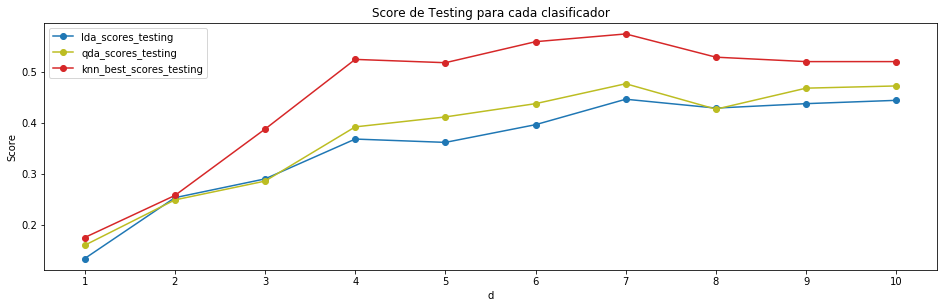

In [20]:
plt.figure(figsize=(16,10))
plt.subplot(211)
plt.xlabel("d")
d = range(1,11)
plt.xticks(d)
plt.ylabel("Score")
plt.title("Score de Testing para cada clasificador")
plt.plot(d,lda_scores_testing, '-o', label='lda_scores_testing', color='tab:blue')
plt.plot(d,qda_scores_testing, '-o', label='qda_scores_testing', color='tab:olive')
plt.plot(d,knn_best_scores_testing, '-o', label='knn_best_scores_testing', color='tab:red')
plt.legend(loc = "best")
plt.show()

En el conjunto de pruebas, El mejor resultado fué obtenido con $d' = 7$ dimensiones y KNN con $k = 2$, con un score de $0.573593073593$. Quizás además sea necesario ver los puntajes en el conjunto de entrenamiento.

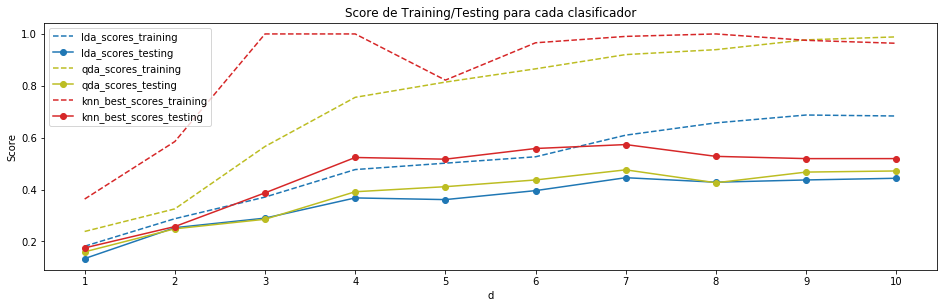

In [21]:
plt.figure(figsize=(16,10))
plt.subplot(211)
plt.xlabel("d")
d = range(1,11)
plt.xticks(d)
plt.ylabel("Score")
plt.title("Score de Training/Testing para cada clasificador")
plt.plot(d,lda_scores_training, '--', label='lda_scores_training', color='tab:blue')
plt.plot(d,lda_scores_testing, '-o', label='lda_scores_testing', color='tab:blue')
plt.plot(d,qda_scores_training, '--', label='qda_scores_training', color='tab:olive')
plt.plot(d,qda_scores_testing, '-o', label='qda_scores_testing', color='tab:olive')
plt.plot(d,knn_best_scores_training, '--', label='knn_best_scores_training', color='tab:red')
plt.plot(d,knn_best_scores_testing, '-o', label='knn_best_scores_testing', color='tab:red')
plt.legend(loc = "best")
plt.show()

Vemos que en general KNN y QDA tienen buen puntaje en el conjunto de entrenamiento al usar $3$ o más dimensiones, pero más allá de $7$ dimensiones el puntaje se estanca o baja para los datos de prueba. Por lo tanto, tendremos 7 dimensiones como el mejor valor.

Finalmente se mostrarán gráficos similares, pero con el error de clasificación (el cual se puede ver como $1 - score$)

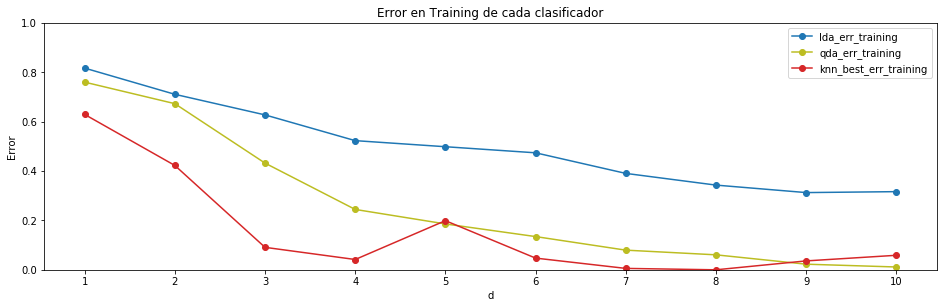

In [22]:
plt.figure(figsize=(16,10))
plt.subplot(211)
plt.xlabel("d")
d = range(1,11)
plt.xticks(d)
plt.ylim([0,1])
plt.ylabel("Error")
plt.title("Error en Training de cada clasificador")
plt.plot(d,lda_err_training, '-o', label='lda_err_training', color='tab:blue')
plt.plot(d,qda_err_training, '-o', label='qda_err_training', color='tab:olive')
plt.plot(d,knn_best_err_training, '-o', label='knn_best_err_training', color='tab:red')
plt.legend(loc = "best")
plt.show()

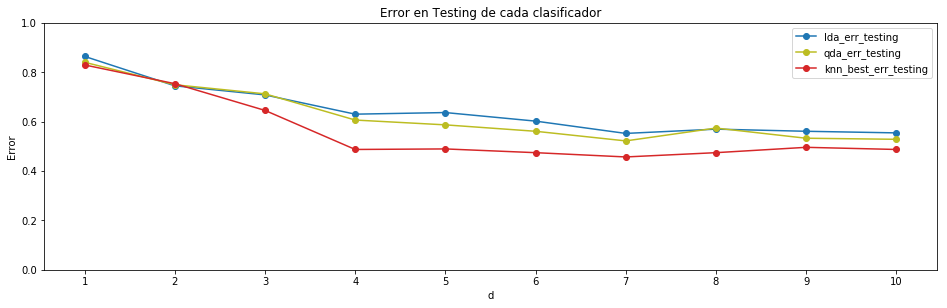

In [23]:
plt.figure(figsize=(16,10))
plt.subplot(211)
plt.xlabel("d")
d = range(1,11)
plt.xticks(d)
plt.ylim([0,1])
plt.ylabel("Error")
plt.title("Error en Testing de cada clasificador")
plt.plot(d,lda_err_testing, '-o', label='lda_err_testing', color='tab:blue')
plt.plot(d,qda_err_testing, '-o', label='qda_err_testing', color='tab:olive')
plt.plot(d,knn_best_err_testing, '-o', label='knn_best_err_testing', color='tab:red')
plt.legend(loc = "best")
plt.show()

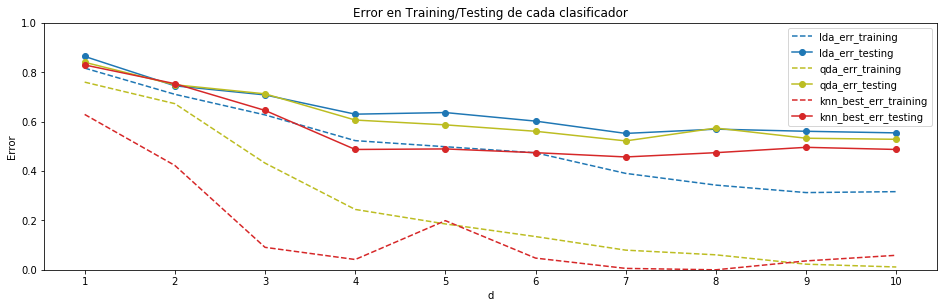

In [24]:
plt.figure(figsize=(16,10))
plt.subplot(211)
plt.xlabel("d")
d = range(1,11)
plt.xticks(d)
plt.ylim([0,1])
plt.ylabel("Error")
plt.title("Error en Training/Testing de cada clasificador")
plt.plot(d,lda_err_training, '--', label='lda_err_training', color='tab:blue')
plt.plot(d,lda_err_testing, '-o', label='lda_err_testing', color='tab:blue')
plt.plot(d,qda_err_training, '--', label='qda_err_training', color='tab:olive')
plt.plot(d,qda_err_testing, '-o', label='qda_err_testing', color='tab:olive')
plt.plot(d,knn_best_err_training, '--', label='knn_best_err_training', color='tab:red')
plt.plot(d,knn_best_err_testing, '-o', label='knn_best_err_testing', color='tab:red')
plt.legend(loc = "best")
plt.show()

## i) Clasificación con reducción de dimensionalidad usando LDA: LDA, QDA y k-Nearest Neighbours

Ahora se hará el mismo ejercicio, pero usando LDA para la reducción de dimensionalidad.

In [25]:
lda_scores_training_two, lda_scores_testing_two, qda_scores_training_two, qda_scores_testing_two = [], [], [], []
knn_best_scores_training_two, knn_best_scores_testing_two = [], []

lda_err_training_two, lda_err_testing_two, qda_err_training_two, qda_err_testing_two = [], [], [], []
knn_best_err_training_two, knn_best_err_testing_two = [], []


for i in range(1,11):
    print("\n", "d' =", i,"\n")
    
    #Se reduce la dimensionalidad con LDA
    sklearn_lda_temp = LDA(n_components=i)
    lda_model_temp = sklearn_lda_temp.fit(X_std, y)
    X_lda_train_temp = lda_model_temp.transform(X_std)
    X_lda_test_temp = lda_model_temp.transform(X_std_test)
    
    
    # Caso 1: LDA
    lda_model = LDA()
    lda_model.fit(X_lda_train_temp,y)
    
    # Se calcula score y error de LDA
    lda_scores_training_two.append(lda_model.score(X_lda_train_temp,y))
    lda_scores_testing_two.append(lda_model.score(X_lda_test_temp,ytest))
    print("LDA => Score with training set:", lda_scores_training_two[-1], ", Score with testing set:", lda_scores_testing_two[-1])
    yhat_training = lda_model.predict(X_lda_train_temp)
    yhat_testing = lda_model.predict(X_lda_test_temp)
    lda_err_training_two.append(get_error(yhat_training, y))
    lda_err_testing_two.append(get_error(yhat_testing, ytest))
    
    # Caso 2: QDA
    qda_model = QDA()
    qda_model.fit(X_lda_train_temp,y)
    
    # Se calcula score y error de QDA
    qda_scores_training_two.append(qda_model.score(X_lda_train_temp,y))
    qda_scores_testing_two.append(qda_model.score(X_lda_test_temp,ytest))
    print("QDA => Score with training set:", qda_scores_training_two[-1], ", Score with testing set:", qda_scores_testing_two[-1])
    yhat_training = qda_model.predict(X_lda_train_temp)
    yhat_testing = qda_model.predict(X_lda_test_temp)
    qda_err_training_two.append(get_error(yhat_training, y))
    qda_err_testing_two.append(get_error(yhat_testing, ytest))
    
    # Caso 2: KNN
    knn_scores_training = []
    knn_scores_testing = []
    knn_err_training = []
    knn_err_testing = []
    k = range(1,51)
    # Se prueba con k entre 1 y 50
    for c in k:
        knn_model = KNeighborsClassifier(n_neighbors=c)
        knn_model.fit(X_lda_train_temp,y)
        knn_scores_training.append(knn_model.score(X_lda_train_temp,y))
        knn_scores_testing.append(knn_model.score(X_lda_test_temp,ytest))
        knn_err_training.append(get_error(knn_model.predict(X_lda_train_temp), y))
        knn_err_testing.append(get_error(knn_model.predict(X_lda_test_temp), ytest))
        

    # Se obtiene el k con mejor score
    knn_max_testing = max(knn_scores_testing)
    knn_max_testing_index = knn_scores_testing.index(knn_max_testing)
    
    # Se calcula score y error de KNN usando el k con menor error de prueba
    knn_best_scores_training_two.append(knn_scores_training[knn_max_testing_index])
    knn_best_scores_testing_two.append(knn_max_testing)
    print("KNN => Score with training set:", knn_best_scores_training_two[-1], ", Score with testing set:", knn_best_scores_testing_two[-1])
    print("Best k for the testing set is", knn_max_testing_index+1)
    knn_best_err_training_two.append(knn_err_training[knn_max_testing_index+1])
    knn_best_err_testing_two.append(knn_err_testing[knn_max_testing_index+1])
    


 d' = 1 

LDA => Score with training set: 0.388257575758 , Score with testing set: 0.300865800866
QDA => Score with training set: 0.390151515152 , Score with testing set: 0.309523809524
KNN => Score with training set: 0.407196969697 , Score with testing set: 0.311688311688
Best k for the testing set is 40

 d' = 2 

LDA => Score with training set: 0.649621212121 , Score with testing set: 0.508658008658
QDA => Score with training set: 0.653409090909 , Score with testing set: 0.538961038961
KNN => Score with training set: 0.674242424242 , Score with testing set: 0.5670995671
Best k for the testing set is 33

 d' = 3 

LDA => Score with training set: 0.670454545455 , Score with testing set: 0.504329004329
QDA => Score with training set: 0.714015151515 , Score with testing set: 0.515151515152
KNN => Score with training set: 0.700757575758 , Score with testing set: 0.556277056277
Best k for the testing set is 21

 d' = 4 

LDA => Score with training set: 0.670454545455 , Score with testing

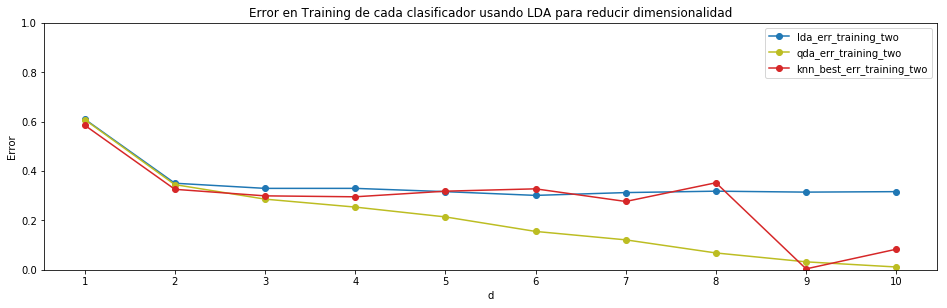

In [26]:
plt.figure(figsize=(16,10))
plt.subplot(211)
plt.xlabel("d")
d = range(1,11)
plt.xticks(d)
plt.ylim([0,1])
plt.ylabel("Error")
plt.title("Error en Training de cada clasificador usando LDA para reducir dimensionalidad")
plt.plot(d,lda_err_training_two, '-o', label='lda_err_training_two', color='tab:blue')
plt.plot(d,qda_err_training_two, '-o', label='qda_err_training_two', color='tab:olive')
plt.plot(d,knn_best_err_training_two, '-o', label='knn_best_err_training_two', color='tab:red')
plt.legend(loc = "best")
plt.show()

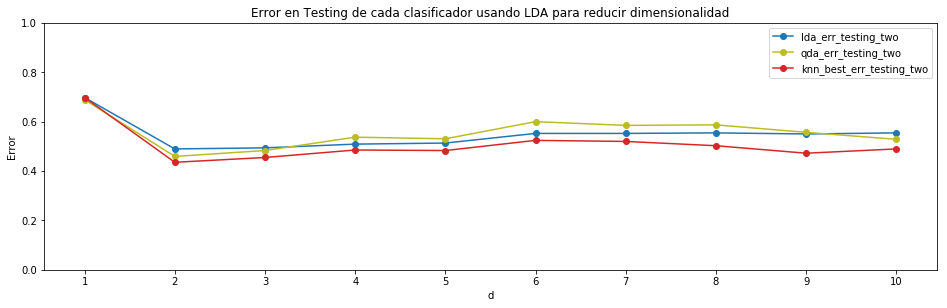

In [27]:
plt.figure(figsize=(16,10))
plt.subplot(211)
plt.xlabel("d")
d = range(1,11)
plt.xticks(d)
plt.ylim([0,1])
plt.ylabel("Error")
plt.title("Error en Testing de cada clasificador usando LDA para reducir dimensionalidad")
plt.plot(d,lda_err_testing_two, '-o', label='lda_err_testing_two', color='tab:blue')
plt.plot(d,qda_err_testing_two, '-o', label='qda_err_testing_two', color='tab:olive')
plt.plot(d,knn_best_err_testing_two, '-o', label='knn_best_err_testing_two', color='tab:red')
plt.legend(loc = "best")
plt.show()

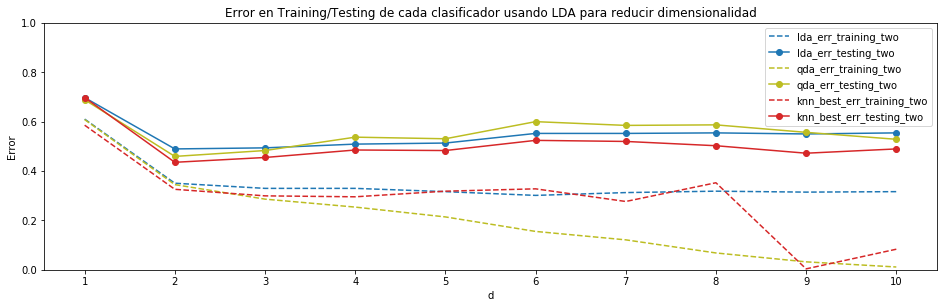

In [28]:
plt.figure(figsize=(16,10))
plt.subplot(211)
plt.xlabel("d")
d = range(1,11)
plt.xticks(d)
plt.ylim([0,1])
plt.ylabel("Error")
plt.title("Error en Training/Testing de cada clasificador usando LDA para reducir dimensionalidad")
plt.plot(d,lda_err_training_two, '--', label='lda_err_training_two', color='tab:blue')
plt.plot(d,lda_err_testing_two, '-o', label='lda_err_testing_two', color='tab:blue')
plt.plot(d,qda_err_training_two, '--', label='qda_err_training_two', color='tab:olive')
plt.plot(d,qda_err_testing_two, '-o', label='qda_err_testing_two', color='tab:olive')
plt.plot(d,knn_best_err_training_two, '--', label='knn_best_err_training_two', color='tab:red')
plt.plot(d,knn_best_err_testing_two, '-o', label='knn_best_err_testing_two', color='tab:red')
plt.legend(loc = "best")
plt.show()

Finalmente, se comparan los resultados al reducir la dimensionalidad usando PCA y LDA, para ambos datasets: entrenamiento y prueba.

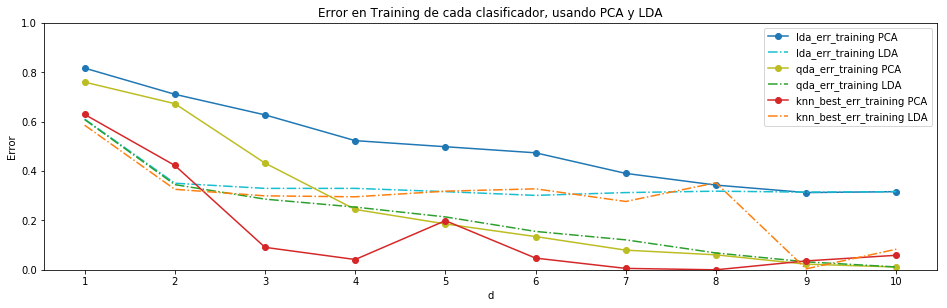

In [29]:
plt.figure(figsize=(16,10))
plt.subplot(211)
plt.xlabel("d")
d = range(1,11)
plt.xticks(d)
plt.ylim([0,1])
plt.ylabel("Error")
plt.title("Error en Training de cada clasificador, usando PCA y LDA")
plt.plot(d,lda_err_training, '-o', label='lda_err_training PCA', color='tab:blue')
plt.plot(d,lda_err_training_two, '-.', label='lda_err_training LDA', color='tab:cyan')
plt.plot(d,qda_err_training, '-o', label='qda_err_training PCA', color='tab:olive')
plt.plot(d,qda_err_training_two, '-.', label='qda_err_training LDA', color='tab:green')
plt.plot(d,knn_best_err_training, '-o', label='knn_best_err_training PCA', color='tab:red')
plt.plot(d,knn_best_err_training_two, '-.', label='knn_best_err_training LDA', color='tab:orange')
plt.legend(loc = "best")
plt.show()

Aquí se ve algo bastante interesante. En general, al utilizar LDA para reducir la dimensionalidad de los datos, el error se mantiene cercano a 0.4 en el conjunto de entramiento, excepto por el caso de clasificación con QDA (donde se va reduciendo de a poco) y el caso de KNN con 9 dimensiones. Sin embargo, al usar PCA para reducir la dimensionalidad, los errores se mantienen altos con valores de d bajos, y la forma en que cambian los errores a medida que aumenta d' es muy distinta para cada modelo: mientras que LDA mantiene un error alto, QDA va en bajada, y KNN logra el error mínimo entre todos.

Si bien podemos decir que usando la tupla (PCA,KNN) nos da un error muy bajo en el conjunto de entrenamiento, es necesario revisar el error en el conjunto de pruebas.

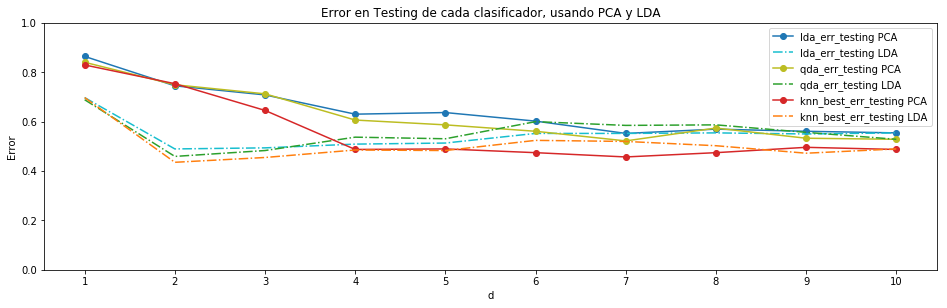

In [30]:
plt.figure(figsize=(16,10))
plt.subplot(211)
plt.xlabel("d")
d = range(1,11)
plt.xticks(d)
plt.ylim([0,1])
plt.ylabel("Error")
plt.title("Error en Testing de cada clasificador, usando PCA y LDA")
plt.plot(d,lda_err_testing, '-o', label='lda_err_testing PCA', color='tab:blue')
plt.plot(d,lda_err_testing_two, '-.', label='lda_err_testing LDA', color='tab:cyan')
plt.plot(d,qda_err_testing, '-o', label='qda_err_testing PCA', color='tab:olive')
plt.plot(d,qda_err_testing_two, '-.', label='qda_err_testing LDA', color='tab:green')
plt.plot(d,knn_best_err_testing, '-o', label='knn_best_err_testing PCA', color='tab:red')
plt.plot(d,knn_best_err_testing_two, '-.', label='knn_best_err_testing LDA', color='tab:orange')
plt.legend(loc = "best")
plt.show()

Se puede ver que en general, los algoritmos van **tendiendo a converger a errores cercanos a** $0.5$ en el conjunto de pruebas. Con LDA, al aumentar las dimensiones más allá de 2, el error va subiendo, y con PCA, el error va bajando hasta estancarse más allá de 7 dimensiones. Usando PCA para reducir dimensionalidad, KNN sería el mejor modelo, seguido por QDA y luego LDA. Usando LDA para reducir dimensionalidad, KNN es el mejor, seguido por LDA y luego QDA.

El hecho de que KNN supere a QDA indica que probablemente los supuestos de QDA sobre Distribuión Gaussiana Multivariada no se cumplen, y no se llega a la optimalidad con éste. Lo mismo con LDA y su suposición de matrices de covarianzas iguales.

Esto nos demuestra que el problema en sí es **complicado**, y teniendo o no un buen desempeño en el conjunto de entrenamiento, los modelos de clasificación lineal van a tener problemas con los sonidos fonéticos de este *dataset*. Por lo tanto, **se debe evaluar la utilización de otros modelos o técnicas distintas**, o de intentar **trabajar con otra representación de los datos**: es posible que las 10 características entregadas por el dataset no sean suficientes.

# 2. Análisis de Opiniones sobre Películas

El análisis de sentimiento (o minerı́a de opiniones) se refiere al proceso de **extraer información acerca de
la actitud que una persona (o grupo de ellas) manifiesta, en un determinado medio o formato digital, con
respecto a un tópico o contexto de comunicación**. Uno de los casos más estudiados corresponde a determinar
la polaridad de un trozo de texto, es decir, clasificar una determinada evaluación escrita (también llamada reseña ó *review*) como positiva, negativa o neutral. La dificultad de este problema radica en el **carácter altamente ambiguo e informal del lenguaje** que utilizan naturalmente las personas, así como el manejo de negaciones, sarcasmo y abreviaciones en una frase.

## a) Ingreso de los datos

In [31]:
#Se contruye el data frame 
train_data_url = "http://www.inf.utfsm.cl/~jnancu/stanford-subset/polarity.train"
test_data_url = "http://www.inf.utfsm.cl/~jnancu/stanford-subset/polarity.dev"
train_data_f = urllib.request.urlretrieve(train_data_url, "train_data_item2.csv")
test_data_f = urllib.request.urlretrieve(test_data_url, "test_data_item2.csv")
ftr = open("train_data_item2.csv", "r", errors="replace")
fts = open("test_data_item2.csv", "r", errors="replace")
rows = [line.split(" ",1) for line in ftr.readlines()]
train_df = pd.DataFrame(rows, columns=['Sentiment','Text'])
train_df['Sentiment'] = pd.to_numeric(train_df['Sentiment'])
rows = [line.split(" ",1) for line in fts.readlines()]
test_df = pd.DataFrame(rows, columns=['Sentiment','Text'])
test_df['Sentiment'] = pd.to_numeric(test_df['Sentiment'])

Para este dataset tenemos que la cantidad de clases estará dada por la columna "Sentiment" del dataset, donde existen dos valores posibles $+1$ para comentarios positivos y $-1$ para comentarios negativos.

In [32]:
test_df.head()

,Sentiment,Text
0,-1,screenwriter dan schneider and director shawn ...
1,-1,"home alone goes hollywood , a funny premise un..."
2,1,seldom has a movie so closely matched the spir...
3,-1,"less dizzying than just dizzy , the jaunt is p..."
4,-1,an ultra-low-budget indie debut that smacks mo...


Por otro lado, la cantidad de registros totales que incluye cada data set será:

In [33]:
count_train_df = pd.value_counts(train_df['Sentiment'].values, sort=False)
count_test_df = pd.value_counts(test_df['Sentiment'].values, sort=False)
print("================Conjunto de entrenamiento================")
print("La cantidad de elementos que tienen la clase +1 es: ",count_train_df[1])
print("La cantidad de elementos que tienen la clase -1 es: ",count_train_df[-1])
print("Total:",train_df.shape[0], "registros")
print("=========================================================")
print("================Conjunto de prueba=======================")
print("La cantidad de elementos que tienen la clase +1 es: ",count_test_df[1])
print("La cantidad de elementos que tienen la clase -1 es: ",count_test_df[-1])
print("Total:",test_df.shape[0], "registros")
print("=========================================================")

================Conjunto de entrenamiento================
La cantidad de elementos que tienen la clase +1 es:  1770
La cantidad de elementos que tienen la clase -1 es:  1784
Total: 3554 registros
================Conjunto de prueba=======================
La cantidad de elementos que tienen la clase +1 es:  1751
La cantidad de elementos que tienen la clase -1 es:  1803
Total: 3554 registros


Como podemos apreciar, existe un pequeño desbalance en la cantidad de registros que tiene cada clase en los conjuntos de datos, ya que para ambos casos (entrenamiento y test) la clase $-1$ tiene más registros, pero como la diferencia es practicamente despreciable supondremos que no representará un problema a la hora de clasificar los datos.

## b) Preprocesamiento: Construcción de funciones de apoyo

Antes de intentar crear un modelo de clasificación, será necesario hacer un preprocesamiento de las *reviews*. Por lo tanto, se definirán dos acciones que se pueden realizar:

* **Eliminación de *stop words* **, las cuales también son llamadas "palabras vacías". Éstas son las palabras que de antemano sabemos que no serán útiles en este análisis (como son los artículos tipo "The", por ejemplo).
* **Stemming**, que es un proceso encargado de quitar inflexiones y conjugaciones de las palabras, con tal de sólo dejar ciertas palabras base o raíz (en general, "cortando" partes de las palabras). Esto busca que la forma de las palabras no penalice la frecuencia de éstas, ya que una palabra puede estar conjugada de varias formas (género, número, persona, etc.) y sin una transformación, los modelos la considerarán (en muchas ocasiones) como términos independientes. Por ejemplo, las palabras "running" y "runner" pueden ser transformadas en su palabra raíz "run", y contar como varias instancias de esta última.

Para implementar estas acciones, se definirán dos funciones de preprocesamiento de la columna Text de un *dataset*:

* La función ** *word_extractor* **, la cual elimina *stop words* y aplica *stemming* mediante el **Algoritmo de Porter**, el cual fue creado en 1980 y si bien es algo extenso, se resume en realizar 5 pasos de reducción de las palabras a partir de un conjunto de reglas. [Porter] 
* La función ** *word_extractor_simple* ** que a diferencia de la anterior, sólo quita las *stop words* de cada frase.

In [34]:
import re, time
from nltk.corpus import stopwords
from nltk import WordNetLemmatizer, word_tokenize
from nltk.stem.porter import PorterStemmer

def word_extractor(text,include_stopwords = False):
    ps = PorterStemmer()
    text = re.sub(r'([a-z])\1+', r'\1\1',text)
    words = ""
    wordtokens = [ ps.stem(word.lower()) for word in word_tokenize(text) ]
    if include_stopwords == False:
        commonwords = stopwords.words('english')
        commonwords.remove("not")
        for word in wordtokens:
            if word not in commonwords:
                words+=" "+word
    else:
        for word in wordtokens:
            words+=" "+word
    return words

def word_extractor_simple(text):
    ps = PorterStemmer()
    #Se eliminan las "palabras vacias"
    commonwords = stopwords.words('english')
    commonwords.remove("not")
    text = re.sub(r'([a-z])\1+', r'\1\1',text)
    words = ""
    wordtokens = [ word.lower() for word in word_tokenize(text) ]
    for word in wordtokens:
        #Se dejan solo las palabras relevantes
        if word not in commonwords:
            words+=" "+word
    return words                   

A contuacion se probará el uso de ambas funciones con algunas palabras de prueba.

In [35]:
print("=====================================================")
print("Pruebas quitando stop words y usando Porter Stemmer ")
print("=====================================================")
print(word_extractor("I love to eat cake",False))
print(word_extractor("I love eating cake",False))
print(word_extractor("I loved eating the cake",False))
print(word_extractor("I do not love eating cake",False))
print(word_extractor("I don't love eating cake",False))
print(word_extractor("You awaked late",False))
print(word_extractor("You awoke late",False))
print(word_extractor("You have been awaking late",False))
print(word_extractor("I would have awaken",False))
print("=====================================================")
print("Pruebas solo quitando stop words")
print("=====================================================")
print(word_extractor_simple("I love to eat cake"))
print(word_extractor_simple("I love eating cake"))
print(word_extractor_simple("I loved eating the cake"))
print(word_extractor_simple("I do not love eating cake"))
print(word_extractor_simple("I don't love eating cake"))
print(word_extractor_simple("You awoke late"))
print(word_extractor_simple("You have been awaking late"))
print(word_extractor_simple("I would have awaken"))

Pruebas quitando stop words y usando Porter Stemmer 
 love eat cake
 love eat cake
 love eat cake
 not love eat cake
 n't love eat cake
 awak late
 awok late
 awak late
 would awaken
Pruebas solo quitando stop words
 love eat cake
 love eating cake
 loved eating cake
 not love eating cake
 n't love eating cake
 awoke late
 awaking late
 would awaken


Como podemos apreciar la diferencia es evidente, ya que al agregar el Porter Stemmer al preprocesamiento y quedando sólo la raiz de la palabra, la frecuencia de esta aumenta, mientras que al solo quitar las *stop words* las conjugaciones de cada palabra se mantienen y serán consideradas como palabras diferentes.

## c) Preprocesamiento alternativo: Lematización


En esta sección se presentará la implementacion de una función alternativa para realizar el preprocesamiento de las palabras contenidas en el dataset. Se llamará *word_extractor2* y la diferencia con las demás radica en que se sustituirá el uso de Stemming por un algoritmo de lematización.

La lematización es un proceso lingüístico que consiste en, dada una forma flexionada (es decir, en plural, en femenino, conjugada, etc), se encuentra el lema correspondiente. El lema es la forma que por convenio se acepta como representante de todas las formas flexionadas de una misma palabra. Es decir, el lema de una palabra es la palabra que nos encontraríamos como entrada en un diccionario tradicional: singular para sustantivos, masculino singular para adjetivos, infinitivo para verbos.

Este proceso, por lo tanto, es más complicado que el simple "corte" de palabras del Stemming, y requiere el uso de diccionarios de palabras. De esta forma, se pueden evitar algunos problemas del Stemming, por ejemplo, los casos donde la raíz o *stem* de una palabra puede ser la misma para las formas flexionadas de lemas diferentes, lo que va a proporcionar ruido a nuestros resultados.

In [36]:
import nltk
from nltk import pos_tag
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Boti\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [37]:
# Correción aportada por Francisco Casas en el moodle del curso
# https://moodle.inf.utfsm.cl/mod/forum/discuss.php?d=31466

def get_wordnet_tag(tag):
    if tag.startswith('JJ'):
        return 'a'
    elif tag.startswith('RB') or tag == "WRB":
        return 'r'
    elif tag.startswith('NN') or tag.startswith("WP"):
        return 'n'
    elif tag.startswith('VB'):
        return 'v'
    else:
        return None

def lemmatize_words(lemmatizer,words):
    tagged = pos_tag(words)
    lemmas = []
    for word, tag in tagged:
        wntag = get_wordnet_tag(tag)
        if wntag is None:
            lemma = lemmatizer.lemmatize(word)
        else:
            lemma = lemmatizer.lemmatize(word,pos=wntag)
        lemmas.append(lemma)
    return lemmas

In [38]:
def word_extractor2(text,include_stopwords = False):
    wordlemmatizer = WordNetLemmatizer()
    text = re.sub(r'([a-z])\1+', r'\1\1',text)
    words = ""
    wordtokens = lemmatize_words(wordlemmatizer,word_tokenize(text.lower()))
    if include_stopwords == False:
        commonwords = stopwords.words('english')
        commonwords.remove("not")
        for word in wordtokens:
            if word not in commonwords:
                words+=" "+word
    else:
        for word in wordtokens:
            words+=" "+word
    return words

Ahora se efectuarán algunas pruebas

In [39]:
print("===============================")
print("Pruebas usando lematización")
print("===============================")
print(word_extractor2("I love to eat cake",False))
print(word_extractor2("I love eating cake",False))
print(word_extractor2("I loved eating the cake",False))
print(word_extractor2("I do not love eating cake",False))
print(word_extractor2("I don't love eating cake",False))
print(word_extractor2("You awoke late",False))
print(word_extractor2("You have been awaking late",False))
print(word_extractor2("I would have awaken",True))

Pruebas usando lematización
 love eat cake
 love eat cake
 love eat cake
 not love eat cake
 n't love eat cake
 awake late
 awake late
 i would have awaken


Comparando los resultados obtenidos en este punto con el anterior podemos verificar que el uso de la lematizacion es mas preciso que el uso de algún *Stemmer*, por ejemplo, para las conjugaciones del verbo *awake* el uso de *stemming* entregó dos raíces distintas, mientras que la lematizacion entregó para todas sus conjugaciones el mismo lemma.

## d) Extracción de características a partir del texto

A continuación se hará una representación vectorial de las reseñas, mediante una matriz que indica, por cada *review* (una fila) las veces en que se presenta cada posible palabra (siendo cada palabra una columna, y los datos la cantidad). Para ello, se utilizará la función *CountVectorizer* de Scikit Learn y las tres funciones de preprocesamiento implementadas anteriormente, para así poder comparar los resultados con cada una. 

De aquí en adelante a *word_extractor_simple* le llamaremos "Simple", a *word_extractor* le llamaremos "Porter" y a *word_extractor2* le llamaermos "Lemmatizer".

In [40]:
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from tabulate import tabulate

def vect_rep(train_df, test_df, v = "porter", include_stopwords = False, v1 = "train"):
    if v == "porter":
        texts_train = [word_extractor(text,include_stopwords) for text in train_df.Text]
        texts_test = [word_extractor(text,include_stopwords) for text in test_df.Text]
    if v == "lem":
        texts_train = [word_extractor2(text,include_stopwords) for text in train_df.Text]
        texts_test = [word_extractor2(text,include_stopwords) for text in test_df.Text]
    if v == "simple":
        texts_train = [word_extractor_simple(text) for text in train_df.Text]
        texts_test = [word_extractor_simple(text) for text in test_df.Text]
    vectorizer = CountVectorizer(ngram_range=(1, 1), binary='False')
    vectorizer.fit(np.asarray(texts_train))
    vocab = vectorizer.get_feature_names()
    if v1 == "train":
        features_train = vectorizer.transform(texts_train)
        labels_train = np.asarray((train_df.Sentiment.astype(float)+1)/2.0)
        dist=list(np.array(features_train.sum(axis=0)).reshape(-1,))
        features = features_train
        labels = labels_train
    if v1 == "test":
        features_test = vectorizer.transform(texts_test)
        labels_test = np.asarray((test_df.Sentiment.astype(float)+1)/2.0)
        dist=list(np.array(features_test.sum(axis=0)).reshape(-1,))
        features = features_test
        labels = labels_test
    #Se modifica el codigo original para guardar cada tag y su frecuencia 
    frec_tag = []
    for tag, count in zip(vocab, dist):
        frec_tag.append([count, tag])
    return frec_tag,features,labels

In [41]:
def n_more_frequent(l,n):
    # Se ordenan de manera descendente
    sorted_tags = sorted(l, reverse=True)
    # Se guardan las n palabras mas frecuentes
    elements = []
    for i in range(n):
        elements.append(sorted_tags[i])
    return elements

def tab(a,b,c,n):
    aa = n_more_frequent(a,n)
    bb = n_more_frequent(b,n)
    cc = n_more_frequent(c,n)
    from tabulate import tabulate
    tab = []
    for i  in range(len(aa)):
        tab.append([aa[i],bb[i],cc[i]])
    return tab   

In [42]:
a,features_train_porter,labels_train_porter = vect_rep(train_df, test_df, "porter",False,"train")
b,features_train_lem,labels_train_lem = vect_rep(train_df, test_df, "lem",False,"train")
e,features_train_simple,labels_train_simple = vect_rep(train_df, test_df, "simple","train")

In [43]:
c,features_test_porter,labels_test_porter = vect_rep(train_df, test_df, "porter",False,"test")
d,features_test_lem,labels_test_lem = vect_rep(train_df, test_df, "lem",False,"test")
f,features_test_simple,labels_test_simple = vect_rep(train_df, test_df, "simple","test")

In [44]:
n = 15
tab_train = tab(a,b,e,n)
tab_test = tab(c,d,f,n)

print("Las",n,"palabras mas frecuentes para el conjunto de entrenamiento")
print(tabulate(tab_train, headers=['PorterStemmer', 'wordlemmatizer', 'Simple']))
print("\n")
print("Las",n,"palabras mas frecuentes para el conjunto de prueba")
print(tabulate(tab_test, headers=['PorterStemmer', 'wordlemmatizer','Simple']))

print("\n")
print("Numero de palabras usando conj. de entrenamiento: ")
print("Porter:",features_train_porter.shape[1])
print("Lemmatizacion:",features_train_lem.shape[1])
print("Simple:",features_train_simple.shape[1])

print("\n")
print("Numero de palabras usando conj. de prueba: ")
print("Porter:",features_test_porter.shape[1])
print("Lemmatizacion:",features_test_lem.shape[1])
print("Simple:",features_test_simple.shape[1])

Las 15 palabras mas frecuentes para el conjunto de entrenamiento
PorterStemmer     wordlemmatizer      Simple
----------------  ------------------  -------------------
[575, 'film']     [574, 'film']       [519, 'film']
[477, 'movi']     [481, 'movie']      [421, 'movie']
[425, 'thi']      [266, 'not']        [266, 'not']
[269, 'not']      [264, 'make']       [244, 'like']
[268, 'like']     [254, 'like']       [238, 'one']
[245, 'one']      [246, 'one']        [158, 'story']
[224, 'ha']       [176, 'story']      [143, 'even']
[207, 'make']     [169, 'good']       [140, 'good']
[179, 'hi']       [163, 'character']  [135, 'comedy']
[176, 'stori']    [145, 'comedy']     [128, 'much']
[161, 'charact']  [143, 'time']       [113, 'characters']
[148, 'time']     [143, 'even']       [111, 'well']
[144, 'good']     [129, 'work']       [107, 'time']
[144, 'even']     [128, 'much']       [103, 'make']
[142, 'comedi']   [127, 'well']       [103, 'little']


Las 15 palabras mas frecuentes para el c

Como primera impresión, se ve que usando las 3 funciones de preprocesamiento, algunas palabras muy usadas como "film" y "movie" son vistas en forma común. Sin embargo, podemos notar otras cosas interesantes que avalan nuestras suposiciones sobre las funciones usadas:

* Con Simple, al sólo quitar stop words, obtenemos que la quinceava palabra más común sólo tiene 103 ocurrencias, respecto a 142 y 127, que son las ocurrencias usando Stemmer y Lemmatizer. Todas las palabras con conjugaciones, y las conjugaciones en sí, quedan como palabras independientes y no son parte del conjunto más común. Así, van a quedar muchas palabras que abordan explicaciones y descripciones (como "good", "well", "like", "comedy"), pero que podrían no ser suficientes. Al hacer un modelo de clasificación, todas las palabras de baja frecuencia terminarán siendo ruido, y podríamos estar perdiendo información al quitarlas, o al mantenerlas independientes.


* Con Stemmer, se reduce el espacio de palabras respecto a Simple y Lemmatizer, y se evita que muchas conjugaciones sean descartadas por su poca frecuencia, pero también surge otro problema: el "corte" de palabras no sólo es difícil de interpretar (con palabras como "charact" y "doe" no teniendo una interpretación obvia) si no que ciertas raíces llegan a ser ambiguas. Por ejemplo, "hi" llega a ser una raíz muy común, y palabras totalmente diferentes como "hid", "high", "hill" y "hit" tienen esta raíz. Para evitar esto, es necesario saber el contexto de cada palabra antes de aplicar el "corte".


* Con Lemmatizer vamos a tener un balance entre Simple y Stemmer en el número de palabras posibles, y el uso del conocimiento sobre la lengua inglesa permite discriminar qué palabras vienen de qué *lemma* en forma mucho más inteligente que Stemmer. Por supuesto, aún se tiene el problema de que no se conoce el contexto del uso de las palabras (lo cual es parte de lo que queremos obtener) y el costo computacional de usar Lemmatizer es mayor a un Stemmer, pero los resultados al crear un modelo de clasificación deberían ser mejores.

## e) Evaluación de modelos de clasificación

Antes de crear un modelo de clasificación para nuestro problema de las *reviws*, se explorarán las métricas usadas para evaluar éstas, luego de aplicarlas con un conjunto de pruebas. Así como se utilizó el Error de Clasificación en el problema anterior (el cual simplemente indica si se clasificó bien o no un dato), al estar en un problema de clasificación binaria (con valores de salida posibles: $+1$ y $-1$) podemos utilizar la llamada Matriz de Confusión.
 
 
 <style type="text/css">
.tg  {border-collapse:collapse;border-spacing:0;}
.tg td{font-family:Arial, sans-serif;font-size:14px;padding:10px 5px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;}
.tg th{font-family:Arial, sans-serif;font-size:14px;font-weight:normal;padding:10px 5px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;}
.tg .tg-k0o9{background-color:#ffeeed;vertical-align:top}
.tg .tg-i6eq{background-color:#ffccc9;vertical-align:top}
.tg .tg-yw4l{vertical-align:top}
.tg .tg-a080{background-color:#9aff99;vertical-align:top}
.tg .tg-nj82{background-color:#d1ffd1;vertical-align:top}
</style>
<table class="tg">
  <tr>
    <th class="tg-yw4l"></th>
    <th class="tg-yw4l"></th>
    <th class="tg-yw4l" colspan="2">Clasificado</th>
  </tr>
  <tr>
    <td class="tg-yw4l"></td>
    <td class="tg-yw4l"></td>
    <td class="tg-a080">+1</td>
    <td class="tg-i6eq">-1</td>
  </tr>
  <tr>
    <td class="tg-yw4l" rowspan="2"><b>La Verdad<b><br></td>
    <td class="tg-a080">+1</td>
    <td class="tg-nj82">Verdaderos Positivos<br></td>
    <td class="tg-k0o9">Falsos Negativos<br></td>
  </tr>
  <tr>
    <td class="tg-i6eq">-1</td>
    <td class="tg-k0o9">Falsos Positivos<br></td>
    <td class="tg-nj82">Verdaderos Negativos<br></td>
  </tr>
</table>

A partir de los datos clasificados por un modelo, y por los *labels* de los datos de prueba, podemos ver cómo se hizo cada clasificación, y obtener algunas métricas al respecto.

In [45]:
from sklearn.metrics import classification_report

# Error de clasificacion
def get_error(yhat, ytest):
    error_total = 0
    for i in range(1, len(yhat)):
        if yhat[i] != ytest[i]:
            error_total = error_total + 1
    return error_total / len(yhat)

def score_the_model(model,x,y,xt,yt,text):
    acc_tr = model.score(x,y)
    acc_test = model.score(xt[:-1],yt[:-1])
    error = get_error(model.predict(xt),yt)
    print("Training Accuracy %s: %f"%(text,acc_tr))
    print("Test Accuracy %s: %f"%(text,acc_test))
    print("Error:", error)
    print( "Detailed Analysis Testing Results ...")
    print(classification_report(yt, model.predict(xt), target_names=['+','-']))

Scikit Learn incluye varias métricas en la función *classification_report*, las cuales son:
    
$Precision:$  La precisión es la razón o *ratio* entre las observaciones positivas predichas correctamente y las observaciones positivas predichas totales. Su cálculo está dado por: 

$$\displaystyle \frac{\text{verdadero postivo}}{\text{verdadero positivo} + \text{falso positivo}}$$
<br>

$Recall:$ Esta métrica representa la razón o *ratio* de observaciones positivas predichas correctamente del total de observaciones en la clase actual. Su cálculo está dado por: 

$$\displaystyle \frac{\text{verdadero postivo}}{\text{verdadero positivo} + \text{falso negativo}}$$
<br>

$F1 score:$ Se puede interpretar como un promedio ponderado de la precisión y el recall, donde alcanza su mejor valor en 1 y el peor puntaje en 0. La contribución relativa de la precisión y el recall son iguales. Su cálculo está dado por: 

$$\displaystyle F1 = 2 * \frac{precision * recall}{precision + recall}$$ 

Se dice que un modelo con alta precisión y bajo *recall* no entrega muchos resultados, pero los que entrega son correctos respecto al conjunto de entrenamiento. Un modelo con baja precisión y alto *recall* es al revés, obteniendo muchos resultados pero con *labels* incorrectos. Lo que se busca es un modelo con alta precisión y alto *recall*.[Measures] [PresRecall]

## f) Clasificación mediante Bayes Ingenuo (*Naive Bayes*)

Ahora se procede a crear un modelo de clasificación de frases de reviews utilizando Bayes Ingenuo. Este es un clasificador bastante simple que utiliza la regla de Bayes para obtener $P(y|x_1...x_n)$, asumiendo independencia entre las probabilidades de cada par de características. Se dice que es un clasificador muy rápido y que no requiere una gran cantidad de datos para generar un modelo, y a pesar de ésto, llega a ser útil en variadas aplicaciones.

En este caso, se utilizará la suposición de que los datos de entrada siguen una distribución Bernoulli multivariada (o sea, múltiples características donde los vectores de entrada tienen elementos 1 o 0). Aplicado al procesamiento de textos, se utiliza como información si la palabra está o no en el texto, y no la frecuencia de la palabra. Por lo tanto, cuando una frase de una *review* va a tener una o más instancias de cierta palabra, tendrá un valor de 1 en esta característica, y 0 si no hay instancias.

A continuación se probará Bernoulli Naive Bayes (BNB) con los conjuntos de entranamiento y de prueba, usando varios de los casos de preprocesamiento. Luego, se mostrará una tabla con 15 frases de *input* obtenidas al azar y las probabilidades obtenidas con BNB.

In [46]:
from sklearn.naive_bayes import BernoulliNB
import random

def do_NAIVE_BAYES(x,y,xt,yt):
    model = BernoulliNB()
    model = model.fit(x, y)
    score_the_model(model,x,y,xt,yt,"BernoulliNB")
    return model

def get_model_metrics(features_train,labels_train, features_test, labels_test):
    model=do_NAIVE_BAYES(features_train,labels_train,features_test,labels_test) 
    #print(model.classes_)
    #Retorna la probabilidad de pertenencia para cada clase del modelo usando el vector de test.
    test_pred = model.predict_proba(features_test)
    #Selecciona de forma aleatorea la posicion de 15 elementos en el vector test_pred.
    spl = random.sample(range(len(test_pred)),15)
    data = []
    for text, sentiment in zip(test_df.Text[spl], test_pred[spl]):
        data.append([sentiment, text[0:70]])
    print(tabulate(data, headers=['Sentiment ([P(bad) P(good)])', 'Text'],tablefmt="fancy_grid"))

In [47]:
ftag_1,features_train_porter2,labels_train_porter2 = vect_rep(train_df, test_df, "porter",True,"train")
ftag_2,features_test_porter2,labels_test_porter2 = vect_rep(train_df, test_df, "porter",True,"test")

In [48]:
ftag_3,features_train_lem2,labels_train_lem2 = vect_rep(train_df, test_df, "lem",True,"train")
ftag_4,features_test_lem2,labels_test_lem2 = vect_rep(train_df, test_df, "lem",True,"test")

In [49]:
print("Usando preprocesamiento Porter")
print("-------------------------------------------------------------------")
get_model_metrics(features_train_porter, labels_train_porter, features_test_porter, labels_test_porter)
print("\n")

Usando preprocesamiento Porter
-------------------------------------------------------------------
Training Accuracy BernoulliNB: 0.942600
Test Accuracy BernoulliNB: 0.748100
Error: 0.2518289251547552
Detailed Analysis Testing Results ...
             precision    recall  f1-score   support

          +       0.76      0.75      0.75      1803
          -       0.74      0.75      0.75      1751

avg / total       0.75      0.75      0.75      3554

╒════════════════════════════════╤════════════════════════════════════════════════════════════════════════╕
│ Sentiment ([P(bad) P(good)])   │ Text                                                                   │
╞════════════════════════════════╪════════════════════════════════════════════════════════════════════════╡
│ [ 0.13548273  0.86451727]      │ otto-sallies has a real filmmaker's eye .                              │
├────────────────────────────────┼────────────────────────────────────────────────────────────────────────┤
│ [ 0.

In [50]:
print("Usando preprocesamiento Porter sin quitar las stopwords")
print("-------------------------------------------------------------------")
get_model_metrics(features_train_porter2, labels_train_porter2, features_test_porter2,labels_test_porter2)

Usando preprocesamiento Porter sin quitar las stopwords
-------------------------------------------------------------------
Training Accuracy BernoulliNB: 0.938661
Test Accuracy BernoulliNB: 0.762736
Error: 0.23719752391671356
Detailed Analysis Testing Results ...
             precision    recall  f1-score   support

          +       0.77      0.76      0.77      1803
          -       0.76      0.76      0.76      1751

avg / total       0.76      0.76      0.76      3554

╒═════════════════════════════════════╤════════════════════════════════════════════════════════════════════════╕
│ Sentiment ([P(bad) P(good)])        │ Text                                                                   │
╞═════════════════════════════════════╪════════════════════════════════════════════════════════════════════════╡
│ [ 0.43828235  0.56171765]           │ cool ? this movie is a snow emergency .                                │
├─────────────────────────────────────┼─────────────────────────────

In [51]:
print("Usando Lematizacion")
print("-------------------------------------------------------------------")
get_model_metrics(features_train_lem, labels_train_lem, features_test_lem,labels_test_lem)

Usando Lematizacion
-------------------------------------------------------------------
Training Accuracy BernoulliNB: 0.951604
Test Accuracy BernoulliNB: 0.742753
Error: 0.25717501406865506
Detailed Analysis Testing Results ...
             precision    recall  f1-score   support

          +       0.75      0.74      0.75      1803
          -       0.74      0.74      0.74      1751

avg / total       0.74      0.74      0.74      3554

╒═════════════════════════════════════╤════════════════════════════════════════════════════════════════════════╕
│ Sentiment ([P(bad) P(good)])        │ Text                                                                   │
╞═════════════════════════════════════╪════════════════════════════════════════════════════════════════════════╡
│ [ 0.13518683  0.86481317]           │ finally , a genre movie that delivers -- in a couple of genres , no le │
├─────────────────────────────────────┼─────────────────────────────────────────────────────────────────

In [52]:
print("Usando Lematizacion sin quitar las stopwords")
print("-------------------------------------------------------------------")
get_model_metrics(features_train_lem2, labels_train_lem2, features_test_lem2,labels_test_lem2)

Usando Lematizacion sin quitar las stopwords
-------------------------------------------------------------------
Training Accuracy BernoulliNB: 0.946539
Test Accuracy BernoulliNB: 0.750070
Error: 0.24985931344963422
Detailed Analysis Testing Results ...
             precision    recall  f1-score   support

          +       0.75      0.75      0.75      1803
          -       0.75      0.75      0.75      1751

avg / total       0.75      0.75      0.75      3554

╒════════════════════════════════╤════════════════════════════════════════════════════════════════════════╕
│ Sentiment ([P(bad) P(good)])   │ Text                                                                   │
╞════════════════════════════════╪════════════════════════════════════════════════════════════════════════╡
│ [ 0.04823501  0.95176499]      │ even though we know the outcome , the seesawing of the general's fate  │
├────────────────────────────────┼─────────────────────────────────────────────────────────────────

Vemos que usando Bernoulli Naive Bayes, tan sólo viendo si es que ciertas palabras están en la frase de la *review* o no, podemos llegar a modelos con resultados buenos, cercanos a $0.75$. Extrañamente, el mejor desempeño lo encontramos al utilizar Stemming sin quitar las *stop words* o palabras vacías, llegando a un error de $~0.237$ y métricas cercanas a $0.76$. Sin embargo, hay varias cosas a tomar en cuenta.


* El no eliminar las stop words significa un conjunto de características mayor, y por ende, matrices más grandes, mayor uso de memoria y más tiempo de computación. Si la ganancia en las métricas es cercana a $1%$, puede que sea necesario evaluar hacer un *tradeoff* entre esta ganancia y el costo computacional, especialmente si es que el análisis se hará con *datasets* mucho más grandes.


* En ciertos casos, existen problemas de *underflow* que hacen que Bernoulli Naive Bayes entregue probabilidades muy cercanas a cero para ambas clases. Esto puede ocurrir debido a que las fórmulas de Bayes utilizan divisiones por probabilidades que son muy pequeñas (ya que, teniendo muchas palabras como características, las probabilidades de estas palabras serán muy cercanas a cero) y esto ocasiona que la computación de divisiones con punto flotante pierda precisión. Para resolver este problema, existen varias opciones que no se verán en este documento, pero que deben mencionarse:

    * Utilizar los **logaritmos** de las probabilidades, en vez de las probabilidades en sí, al efectuar los cálculos.
    * Utilizar el **truco *log-sum-exp* **, que extiende la idea de trabajar en el espacio de los logaritmos, mediante la fórmula:
    
    $$ \log \sum_k e^{a_k} = \log \sum_k e^{a_k}e^{A-A} = A+ \log\sum_k e^{a_k -A} $$

    Donde:
    
    $a_k=\log \left(  p(\mathbf{x}|Y=C_k)p(Y=C_k) \right)$,
    
    $A = \underset{k \in \{1, \dots, |C|\}} \max a_k.$
    
    
Para ver más información, revisar las referencias al pié del documento. [LSETrick]


Finalmente, se probará **Multinomial Naive Bayes** (MNB). A diferencia de Bernoulli Naive Bayes, aquí se asume una Distribución Multinomial de los datos (generalización de la Distribución Binomial) y por lo tanto, utiliza directamente la cantidad de ocurrencias de cada palabra para obtener las probabilidades (en vez de simplemente ver si está o no).

In [53]:
from sklearn.naive_bayes import MultinomialNB
import random

def do_NAIVE_BAYES(x,y,xt,yt):
    model = MultinomialNB()
    model = model.fit(x, y)
    score_the_model(model,x,y,xt,yt,"MultinomialNB")
    return model

def get_model_metrics(features_train,labels_train, features_test, labels_test):
    model=do_NAIVE_BAYES(features_train,labels_train,features_test,labels_test) 
    #print(model.classes_)
    #Retorna la probabilidad de pertenencia para cada clase del modelo usando el vector de test.
    test_pred = model.predict_proba(features_test)
    #Selecciona de forma aleatorea la posicion de 15 elementos en el vector test_pred.
    spl = random.sample(range(len(test_pred)),15)
    data = []
    for text, sentiment in zip(test_df.Text[spl], test_pred[spl]):
        data.append([sentiment, text[0:70]])
    print(tabulate(data, headers=['Sentiment ([P(bad) P(good)])', 'Text'],tablefmt="fancy_grid"))


ftag_1,features_train_porter2,labels_train_porter2 = vect_rep(train_df, test_df, "porter",True,"train")
ftag_2,features_test_porter2,labels_test_porter2 = vect_rep(train_df, test_df, "porter",True,"test")

ftag_3,features_train_lem2,labels_train_lem2 = vect_rep(train_df, test_df, "lem",True,"train")
ftag_4,features_test_lem2,labels_test_lem2 = vect_rep(train_df, test_df, "lem",True,"test")

In [54]:
print("Usando preprocesamiento Porter")
print("-------------------------------------------------------------------")
get_model_metrics(features_train_porter, labels_train_porter, features_test_porter, labels_test_porter)
print("\n")

Usando preprocesamiento Porter
-------------------------------------------------------------------
Training Accuracy MultinomialNB: 0.941474
Test Accuracy MultinomialNB: 0.750070
Error: 0.24985931344963422
Detailed Analysis Testing Results ...
             precision    recall  f1-score   support

          +       0.75      0.75      0.75      1803
          -       0.75      0.75      0.75      1751

avg / total       0.75      0.75      0.75      3554

╒═════════════════════════════════════╤════════════════════════════════════════════════════════════════════════╕
│ Sentiment ([P(bad) P(good)])        │ Text                                                                   │
╞═════════════════════════════════════╪════════════════════════════════════════════════════════════════════════╡
│ [ 0.7711057  0.2288943]             │ a glossy knock-off of a b-movie revenge flick .                        │
├─────────────────────────────────────┼──────────────────────────────────────────────────

In [55]:
print("Usando preprocesamiento Porter sin quitar las stopwords")
print("-------------------------------------------------------------------")
get_model_metrics(features_train_porter2, labels_train_porter2, features_test_porter2,labels_test_porter2)

Usando preprocesamiento Porter sin quitar las stopwords
-------------------------------------------------------------------
Training Accuracy MultinomialNB: 0.940630
Test Accuracy MultinomialNB: 0.759640
Error: 0.24029262802476084
Detailed Analysis Testing Results ...
             precision    recall  f1-score   support

          +       0.76      0.77      0.76      1803
          -       0.76      0.75      0.75      1751

avg / total       0.76      0.76      0.76      3554

╒════════════════════════════════╤════════════════════════════════════════════════════════════════════════╕
│ Sentiment ([P(bad) P(good)])   │ Text                                                                   │
╞════════════════════════════════╪════════════════════════════════════════════════════════════════════════╡
│ [ 0.062135  0.937865]          │ 'almodóvar logra un filme entrañable , lleno de compasión , comprensió │
├────────────────────────────────┼──────────────────────────────────────────────────

In [56]:
print("Usando Lematizacion")
print("-------------------------------------------------------------------")
get_model_metrics(features_train_lem, labels_train_lem, features_test_lem,labels_test_lem)

Usando Lematizacion
-------------------------------------------------------------------
Training Accuracy MultinomialNB: 0.951604
Test Accuracy MultinomialNB: 0.742471
Error: 0.2574563871693866
Detailed Analysis Testing Results ...
             precision    recall  f1-score   support

          +       0.75      0.74      0.75      1803
          -       0.74      0.74      0.74      1751

avg / total       0.74      0.74      0.74      3554

╒════════════════════════════════╤════════════════════════════════════════════════════════════════════════╕
│ Sentiment ([P(bad) P(good)])   │ Text                                                                   │
╞════════════════════════════════╪════════════════════════════════════════════════════════════════════════╡
│ [ 0.87357504  0.12642496]      │ it's endearing to hear madame d . refer to her husband as 'jackie' --  │
├────────────────────────────────┼────────────────────────────────────────────────────────────────────────┤
│ [ 0.5910271

In [57]:
print("Usando Lematizacion sin quitar las stopwords")
print("-------------------------------------------------------------------")
get_model_metrics(features_train_lem2, labels_train_lem2, features_test_lem2,labels_test_lem2)

Usando Lematizacion sin quitar las stopwords
-------------------------------------------------------------------
Training Accuracy MultinomialNB: 0.949353
Test Accuracy MultinomialNB: 0.749789
Error: 0.2501406865503658
Detailed Analysis Testing Results ...
             precision    recall  f1-score   support

          +       0.75      0.76      0.76      1803
          -       0.75      0.73      0.74      1751

avg / total       0.75      0.75      0.75      3554

╒════════════════════════════════╤════════════════════════════════════════════════════════════════════════╕
│ Sentiment ([P(bad) P(good)])   │ Text                                                                   │
╞════════════════════════════════╪════════════════════════════════════════════════════════════════════════╡
│ [ 0.06797197  0.93202803]      │ richard gere and diane lane put in fine performances as does french ac │
├────────────────────────────────┼──────────────────────────────────────────────────────────────

Finalmente obtuvimos resultados bastante similares entre Naive Bayes con distribuciones Bernoulli y Multinomial. Otra vez, el error menor se obtuvo usando Stemming sin quitar las *stop words*, con un error $~0.239$ en el caso Multinomial (ligeramente mayor al de Bernoulli).

Podemos concluír en que Naive Bayes, a pesar de su simplicidad, puede llegar a ser útil en casos de análisis de textos, pero que se debe tener en cuenta los distintos tipos de distribuciones (asociadas a las suposiciones sobre los datos, y la información que tendremos en nuestras matrices de entrada), el formato y preprocesamiento de los datos de entrada, y los alcances de los cálculos de probabilidades (los cuales pueden producir errores de underflow bajo las limitaciones del punto flotante).

## g) Clasificación mediante Máquina de Vectores de Soporte (SVM) Lineales

Ahora, vamos a intentar generar modelos de clasificación utilizando SVMs (*Support Vector Machines*), las cuales van a intentar generar un hiperplano que separa las clases en el espacio de los datos, buscando **maximizar el "márgen"** (distancia entre puntos más cercanos entre un par de clases) al encontrar cuáles son los datos que son más relevantes para definir este márgen (los llamados **vectores de soporte**). Esto luego definirá un problema de optimización cuadrático, el cual se puede resolver con varias técnicas conocidas. En el caso de SVM Lineal, se crearán fronteras de decisión lineales (hiperplanos).

Específicamente, se utilizará una C-SVM Lineal, la cual es una SVM que es **capaz de violar las restricciones** del problema de optimización cuadrático, al poder agregar **variables de holgura**. Esto hará que el modelo sea más robusto ante *outliers*, y su holgura se definirá por el hiperparámetro C. Este se puede ver como un parámetro de regularización, ya que controla el *tradeoff* entre un bajo error de clasificación (con un conjunto de pruebas) y un márgen grande y óptimo. 

Por ejemplo, con C tendiendo a infinito, indicamos que queremos penalizar en forma máxima el error de clasificación, y aceptar el márgen máximo posible, con un riesgo de sobreajuste y baja tolerancia a *outliers* (o sea, los outliers son considerados como datos útiles). Con C cercano a cero, se da holgura al error de clasificación y permitiremos que el márgen no sea máximo, pero esta "permisividad" hará que se puedan ignorar outliers, y si bien aumenta el error de clasificación en el conjunto de prueba, nos puede llevar a una separación de las clases con mucho más sentido, y mejor rendimiento en los conjuntos de prueba.

Si bien los valores de C que se prueban en general son potencias de 10 (positivas y negativas), el ajuste de C va a depender mucho de los datos, por lo que se debe sintonizar para cada caso. A continuación se probará una C-SVM Lineal utilizando varios valores de $C \in \{0.01,0.1,10,100,1000\}$. [CParam]

In [58]:
from sklearn.svm import LinearSVC

def do_SVM(x,y,xt,yt):
    Cs = [0.01,0.1,1,10,100,1000]
    for C in Cs:
        print("C Value:",C)
        model = LinearSVC(C=C)
        model = model.fit(x, y)
        print(model.score(xt,yt))
        score_the_model(model,x,y,xt,yt,"SVM")
        print("====================================================")
        
def do_SVM2(x,y,xt,yt,C):
        print("C Value:",C)
        model = LinearSVC(C=C)
        model = model.fit(x, y)
        return model
        
def get_random_set(features_train,labels_train, features_test, labels_test,C,n):
    model = do_SVM2(features_train,labels_train,features_test,labels_test,C)
    #Retorna la probabilidad de pertenencia para cada clase del modelo usando el vector de test.
    #test_pred = model.decision_function(features_test)
    test_pred = model.predict(features_test)
    #Selecciona de forma aleatorea la posicion de 15 elementos en el vector test_pred.
    spl = random.sample(range(len(test_pred)),n)
    data = []
    for text, sentiment in zip(test_df.Text[spl], test_pred[spl]):
        data.append([sentiment, text[0:85]])
    print(tabulate(data, headers=['Sentiment', 'Text'],tablefmt="fancy_grid"))


### Pruebas

En esta parte se utilizará Lematización y Stemming considerando la elieminación de las *stopwords* o "palabras vacias". Además, para poder determinar que modelo se comporta de mejor manera, se van a comparar los *f1 score* obtenidos a partir de los distintos valores de C.

##### Pruebas usando WordNetLemmatizer

In [59]:
do_SVM(features_train_lem,labels_train_lem, features_test_lem, labels_test_lem)

C Value: 0.01
0.710748452448
Training Accuracy SVM: 0.882667
Test Accuracy SVM: 0.710667
Error: 0.289251547552054
Detailed Analysis Testing Results ...
             precision    recall  f1-score   support

          +       0.71      0.73      0.72      1803
          -       0.71      0.70      0.70      1751

avg / total       0.71      0.71      0.71      3554

C Value: 0.1
0.719752391671
Training Accuracy SVM: 0.987338
Test Accuracy SVM: 0.719674
Error: 0.28024760832864376
Detailed Analysis Testing Results ...
             precision    recall  f1-score   support

          +       0.72      0.72      0.72      1803
          -       0.72      0.72      0.72      1751

avg / total       0.72      0.72      0.72      3554

C Value: 1
0.705402363534
Training Accuracy SVM: 0.999156
Test Accuracy SVM: 0.705319
Error: 0.2945976364659538
Detailed Analysis Testing Results ...
             precision    recall  f1-score   support

          +       0.71      0.71      0.71      1803
        

Como podemos apreciar en las pruebas realizadas, los mejores indicadores se obtienen para un valor de $C = 0.1$, teniendo un training accuracy de 0.987338, un test accuracy de 0.719674 para la data de test y un f1 score de 0.72.

Para valores a partir de $C = 1$ el conjunto de entrenamiento tiene un accuracy de 1, lo que hace que se produzca sobreajuste, viendose reflejado en que todos los indicadores a partir de este valor comienzan a decaer mientras más grande es el valor de C.

#### Pruebas usando PorterStemmer

Análogo a lo anterior se realizaran las pruebas sin quitar las *stopwords*, pero esta vez usando Stemming a través del Algoritmo de porter.

In [60]:
do_SVM(features_train_porter,labels_train_porter, features_test_porter, labels_test_porter)

C Value: 0.01
0.729319077096
Training Accuracy SVM: 0.872538
Test Accuracy SVM: 0.729243
Error: 0.2706809229037704
Detailed Analysis Testing Results ...
             precision    recall  f1-score   support

          +       0.73      0.75      0.74      1803
          -       0.73      0.71      0.72      1751

avg / total       0.73      0.73      0.73      3554

C Value: 0.1
0.733539673607
Training Accuracy SVM: 0.981711
Test Accuracy SVM: 0.733465
Error: 0.2664603263927969
Detailed Analysis Testing Results ...
             precision    recall  f1-score   support

          +       0.74      0.74      0.74      1803
          -       0.73      0.73      0.73      1751

avg / total       0.73      0.73      0.73      3554

C Value: 1
0.720596510974
Training Accuracy SVM: 0.999719
Test Accuracy SVM: 0.720518
Error: 0.27940348902644907
Detailed Analysis Testing Results ...
             precision    recall  f1-score   support

          +       0.73      0.72      0.72      1803
       

Para este caso podemos ver que el valor de C que entrega un mejor resultado es $C = 0.1$. Al igual que para el caso anterior podemos notar que a partir de valores $C = 1$ el *training accuracy* es practicamente 1 al mismo tiempo que los indicadores para en el conjunto de *testing* vayan disminuyendo, lo que indica **sobreajuste**.

### Pruebas sin quitar las stopwords

En esta parte se utilizará Lematización y Stemming manteniendo las *stopwords*. Además, al igual que en la parte anterior, se compararán los *f1 score* obtenidos a partir de los distintos valores de C.

##### Pruebas usando WordNetLemmatizer



In [61]:
do_SVM(features_train_lem2,labels_train_lem2, features_test_lem2, labels_test_lem2)

C Value: 0.01
0.714124929657
Training Accuracy SVM: 0.870850
Test Accuracy SVM: 0.714044
Error: 0.2858750703432752
Detailed Analysis Testing Results ...
             precision    recall  f1-score   support

          +       0.72      0.72      0.72      1803
          -       0.71      0.71      0.71      1751

avg / total       0.71      0.71      0.71      3554

C Value: 0.1
0.733258300506
Training Accuracy SVM: 0.986775
Test Accuracy SVM: 0.733183
Error: 0.26674169949352844
Detailed Analysis Testing Results ...
             precision    recall  f1-score   support

          +       0.74      0.73      0.74      1803
          -       0.73      0.74      0.73      1751

avg / total       0.73      0.73      0.73      3554

C Value: 1
0.714406302757
Training Accuracy SVM: 1.000000
Test Accuracy SVM: 0.714326
Error: 0.28559369724254363
Detailed Analysis Testing Results ...
             precision    recall  f1-score   support

          +       0.73      0.70      0.71      1803
      

Nuevamente encontramos que el mejor valor para el parámetro de regularización será $C=0.1$ ya que se obtienen mejores métricas en comparación con las demás pruebas para los diferentes valores de este parámetro. Además, notamos que al mantener las palabras vacías las métricas en general aumentaron, especialmente en los valores mayores a $C=0.01$ en comparación con el caso donde estas se eliminaban.

#### Pruebas usando PorterStemmer

In [62]:
do_SVM(features_train_porter2,labels_train_porter2, features_test_porter2, labels_test_porter2)

C Value: 0.01
0.729881823298
Training Accuracy SVM: 0.868317
Test Accuracy SVM: 0.729806
Error: 0.2698368036015757
Detailed Analysis Testing Results ...
             precision    recall  f1-score   support

          +       0.73      0.74      0.74      1803
          -       0.73      0.72      0.72      1751

avg / total       0.73      0.73      0.73      3554

C Value: 0.1
0.739729881823
Training Accuracy SVM: 0.982836
Test Accuracy SVM: 0.739657
Error: 0.2602701181767023
Detailed Analysis Testing Results ...
             precision    recall  f1-score   support

          +       0.74      0.74      0.74      1803
          -       0.73      0.74      0.74      1751

avg / total       0.74      0.74      0.74      3554

C Value: 1
0.729319077096
Training Accuracy SVM: 1.000000
Test Accuracy SVM: 0.729243
Error: 0.2706809229037704
Detailed Analysis Testing Results ...
             precision    recall  f1-score   support

          +       0.74      0.72      0.73      1803
        

Nuevamente encontramos que el mejor valor para el parametro de regularización será $C=0.1$ ya que se obtienen mejores métricas en comparación con las demás pruebas para los diferentes valores de este parametro. Además notamos que al mantener las palabras vacías las métricas en general aumentaron $0.01$ en comparación con el caso donde estas se eliminaban. 

Finalmente al igual que en Naive Bayes, tenemos que al usar Stemming en el modelo se obtiene un mejor resultado, esto posiblemente a que lo que pensábamos que era "ruido" a la hora de realizar la clasificación va a terminar dando una mayor capacidad de generalizacion al modelo. Tambien logramos identificar en todas nuestras pruebas que el valor óptimo para el parametro de regularizacion será $C = 0.1$ ya que al usarlo siempre y de forma generalizada, se obtenía una mejora para todas métricas.

In [63]:
get_random_set(features_train_porter,labels_train_porter, features_test_porter, labels_test_porter,0.1,10)

C Value: 0.1
╒═════════════╤═══════════════════════════════════════════════════════════════════════════════════════╕
│   Sentiment │ Text                                                                                  │
╞═════════════╪═══════════════════════════════════════════════════════════════════════════════════════╡
│           0 │ an earnest , heartrending look at the divide between religious fundamentalists and th │
├─────────────┼───────────────────────────────────────────────────────────────────────────────────────┤
│           0 │ pray has really done his subject justice .                                            │
├─────────────┼───────────────────────────────────────────────────────────────────────────────────────┤
│           0 │ a baffling subplot involving smuggling drugs inside danish cows falls flat , and if y │
├─────────────┼───────────────────────────────────────────────────────────────────────────────────────┤
│           0 │ as vulgar as it is banal .         

In [64]:
get_random_set(features_train_porter,labels_train_porter, features_test_porter, labels_test_porter,1000,10)

C Value: 1000
╒═════════════╤═══════════════════════════════════════════════════════════════════════════════════════╕
│   Sentiment │ Text                                                                                  │
╞═════════════╪═══════════════════════════════════════════════════════════════════════════════════════╡
│           0 │ makes 98 minutes feel like three hours .                                              │
├─────────────┼───────────────────────────────────────────────────────────────────────────────────────┤
│           1 │ the movie , despite its rough edges and a tendency to sag in certain places , is wry  │
├─────────────┼───────────────────────────────────────────────────────────────────────────────────────┤
│           0 │ while the story is better-focused than the incomprehensible anne rice novel it's base │
├─────────────┼───────────────────────────────────────────────────────────────────────────────────────┤
│           0 │ certainly beautiful to look at , b

Revisando los valores de output dados a las frases de las *reviews*, vemos que la salida es la clase directamente, y no una probabilidad para cada clase como es el caso de Naive Bayes. Esto dado a que la C-SVM Lineal va a crear fronteras de decisión lineales, y simplemente se puede ver en donde cae cada dato de prueba (en este caso, a un lado del hiperplano sería 1 como positivo y al otro lado sería 0 como negativo). Leyendo las frases, se puede ver que ciertas frases se clasificaron bien, pero la ambigüedad del lenguaje hace que, incluso para un humano, la clasificación sea difícil.

Finalmente, se puede concluír que las SVM Lineales pueden ser herramientas poderosas para la clasificación, pero en el caso del análisis de textos, no llega a ser tan precisa como Naive Bayes. Sin embargo, existen varios puntos a tomar en cuenta antes de descartar estos modelos:

* Las C-SVM Lineales son sólo un subconjunto de las SVM que pueden ser utilizadas en la clasificación de textos. Se debe evaluar la utilización de otras variantes de SVM (como nu-SVM).
* El uso de hiperparámetros, como el C de C-SVM, deben ser ajustados en forma específica según el conjunto de datos y el problema a abordar. El uso de cross-validation y Grid Search cross-validation puede ser una opción para los casos con más parámetros, o si deseamos cambiar otros parámetros de C-SVM que no sólo sean el C.
* Se debe tomar en cuenta las diferencias entre SVMs y Naive Bayes: si bien logramos precisiones similares en ambos casos, la forma en que funcionan estos clasificadores es muy distinta. Mientras que SVM se puede ver como una resolución de un problema de optimización basado en maximizar distancia entre las clases en un n-espacio vectorial, Naive Bayes se basa en probabilidades y la independencia de las n características. Este ejercicio es sólo un ejemplo, y no siempre Naive Bayes será mejor que SVM.
* Y como se mencionó antes, otros problemas podrían tener una representación de datos distinta, con muchas más características y datos. El costo computacional de un clasificador puede ser prohibitivo en comparación a otro, por lo que el preprocesamiento no sólo va a afectar los resultados de la clasificación, si no el hecho de que ésta se pueda hacer de por sí.
* El trabajo con lenguaje natural puede que requiera procesos más elaborados que simplemente obtener frecuencias u ocurrencias de palabras: por ejemplo, podría ser útil un modelo que pueda ver conjuntos o tuplas de palabras y asignar un sentimiento (por ejemplo, "pretty bad" es una frase negativa, pero por separado "pretty" puede ser positivo y "bad" negativo).

# 3. Fraude en transacciones bancarias

## a) Ingreso de los datos

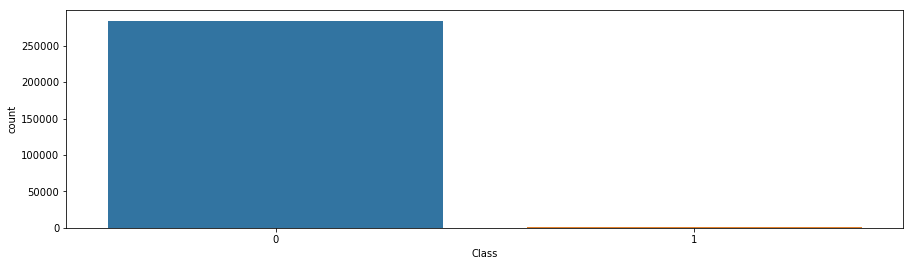

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
dt = pd.read_csv("creditcard.csv",header = 0)
sns.countplot("Class",data=dt)
plt.show()

In [3]:
count_class = pd.value_counts(dt['Class'].values)
print("===================================================")
print("Cantidad de elementos por clase")
print("===================================================")
print("Elementos pertenecientes a la clase 0 es de", count_class[0])
print("Elementos pertenecientes a la clase 1 es de", count_class[1])
print("===================================================")

Cantidad de elementos por clase
Elementos pertenecientes a la clase 0 es de 284315
Elementos pertenecientes a la clase 1 es de 492


Como podemos apreciar el dataset se encuentra desbalanceado y la diferencia es muy significativa, lo que esto puede traer problemas a la hora de hacer la clasificación de los datos. Es decir, la clasificacion puede quedar sesgada hacia la clase que posee una mayor cantidad de elementos.

In [4]:
dt.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


Otro dato a tener en consideración es la cantidad de caracteristicas que posee este dataset, como podemos apreciar este dataset contiene un total de 30 (Tiempo + monto y otras 28 sin nombre).

Algo interesante que podemos ver es que si bien las características $V1..V28$ parecen estar ya escaladas y centradas en cero, la característica Amount no lo está. El siguiente punto tratará sobre esto.

## b) Preprocesamiento: Estandarización de los datos

Al igual que en el documento anterior (de clasificación), se vió que en general los valores monetarios pueden ocasionar problemas de pérdida de precisión (al ser valores muy grandes), pueden tener *skewness* o desbalance (viendo su histograma) y , como punto más importante, varios de los modelos de clasificación asumen que los datos están bajo una misma escala.

Dado a que el valor monetario Amount es parte de las características, no se hará una Tranformación Logarítmica (no es necesario ver el tema del *skewness*) pero si se utilizará StandardScaler para la normalización.

In [5]:
dt.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,3.919560e-15,5.688174e-16,-8.769071e-15,2.782312e-15,-1.552563e-15,2.010663e-15,-1.694249e-15,-1.927028e-16,-3.137024e-15,...,1.537294e-16,7.959909e-16,5.367590e-16,4.458112e-15,1.453003e-15,1.699104e-15,-3.660161e-16,-1.206049e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


In [6]:
from sklearn.preprocessing import StandardScaler
# Se agrega la columna nAmount con los datos de Amount normalizados 
dt["nAmount"] = StandardScaler().fit_transform(dt['Amount'].values.reshape(-1, 1))
# Se eliminan la columna del tiempo y amount
dt.drop(["Time","Amount"],axis=1,inplace=True)

In [7]:
dt.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,Class,nAmount
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0,0.244964
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,0,-0.342475
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,0,1.160686
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0,0.140534
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,0,-0.073403


In [8]:
dt.describe()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,Class,nAmount
count,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,2.848070e+05
mean,3.919560e-15,5.688174e-16,-8.769071e-15,2.782312e-15,-1.552563e-15,2.010663e-15,-1.694249e-15,-1.927028e-16,-3.137024e-15,1.768627e-15,...,1.537294e-16,7.959909e-16,5.367590e-16,4.458112e-15,1.453003e-15,1.699104e-15,-3.660161e-16,-1.206049e-16,0.001727,3.202236e-16
std,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,1.088850e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,0.041527,1.000002e+00
min,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,-2.458826e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,-3.532294e-01
25%,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,-5.354257e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,0.000000,-3.308401e-01
50%,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,-9.291738e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,0.000000,-2.652715e-01
75%,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,4.539234e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,0.000000,-4.471707e-02
max,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,2.374514e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,1.000000,1.023622e+02


## c) Preparación para pruebas con distintos modelos

A continuación se muestra el código que nos permitirá evaluar los modelos de clasificación a usar. Este código incluye algunas de las cosas que se vieron en la sección anterior, como es el uso de una Matriz de Confusión, las métricas de clasificación *precision*, *recall* y *f1 score*, y además agregaremos lo que es la curva ROC.

Recordando lo indicado sobre la Matriz de Confusión, nos permite clasificar los aciertos y errores en la clasificación, según los datos clasificados por un modelo, y por los *labels* de los datos de prueba.

<style type="text/css">
.tg  {border-collapse:collapse;border-spacing:0;}
.tg td{font-family:Arial, sans-serif;font-size:14px;padding:10px 5px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;}
.tg th{font-family:Arial, sans-serif;font-size:14px;font-weight:normal;padding:10px 5px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;}
.tg .tg-k0o9{background-color:#ffeeed;vertical-align:top}
.tg .tg-i6eq{background-color:#ffccc9;vertical-align:top}
.tg .tg-yw4l{vertical-align:top}
.tg .tg-a080{background-color:#9aff99;vertical-align:top}
.tg .tg-nj82{background-color:#d1ffd1;vertical-align:top}
</style>
<table class="tg">
  <tr>
    <th class="tg-yw4l"></th>
    <th class="tg-yw4l"></th>
    <th class="tg-yw4l" colspan="2">Clasificado</th>
  </tr>
  <tr>
    <td class="tg-yw4l"></td>
    <td class="tg-yw4l"></td>
    <td class="tg-a080">+1</td>
    <td class="tg-i6eq">-1</td>
  </tr>
  <tr>
    <td class="tg-yw4l" rowspan="2"><b>La Verdad<b><br></td>
    <td class="tg-a080">+1</td>
    <td class="tg-nj82">Verdaderos Positivos<br></td>
    <td class="tg-k0o9">Falsos Negativos<br></td>
  </tr>
  <tr>
    <td class="tg-i6eq">-1</td>
    <td class="tg-k0o9">Falsos Positivos<br></td>
    <td class="tg-nj82">Verdaderos Negativos<br></td>
  </tr>
</table>


La *Receiver Operating Characteristic curve* o Curva ROC nos permite verificar si un clasificador binario tiene un buen rendimiento a medida que cambia su *threshold* o umbral de discriminación (o sea, el valor entre 0 y 1 en que decidimos si el dato es parte de la clase Positiva). 

En un eje (en general, eje vertical) se tiene la razón de Verdaderos Positivos (también llamada *sensibilidad*) que se define como :

$$\displaystyle \frac{\text{verdadero postivo}}{\text{verdadero positivo} + \text{falso negativos}}$$

En el otro eje (en general, eje horizontal) se tiene la razón de Falsos Positivos, también llamada *fall-out* o "probabilidad de falsa alarma", se define como:

$$\displaystyle \frac{\text{falso positivo}}{\text{falso positivo} + \text{verdadero negativo}}$$

Se busca que el área bajo la curva ROC sea cercana a 1 y alejada de 0.5 (clasificador que adivina aleatoriamiente).

In [9]:
from sklearn.metrics import roc_curve, roc_auc_score

def model(model,features_train,features_test,labels_train,labels_test):
    clf = model
    clf.fit(features_train,labels_train.values.ravel())
    pred=clf.predict(features_test)
    pred_proba = clf.predict_proba(features_test)
    cnf_matrix=confusion_matrix(labels_test,pred)
    print("The recall for this model is: %f"%(float(cnf_matrix[1,1])/(cnf_matrix[1,1]+cnf_matrix[1,0])))
    fig= plt.figure(figsize=(6,3))
    print("TP: %d"%cnf_matrix[1,1,])
    print("TN: %d"%cnf_matrix[0,0])
    print("FP: %d"%cnf_matrix[0,1])
    print("FN: %d"%cnf_matrix[1,0])
    sns.heatmap(cnf_matrix,cmap="coolwarm_r",annot=True,linewidths=0.5)
    plt.title("Confusion_matrix")
    plt.xlabel("Predicted_class")
    plt.ylabel("Real class")
    plt.show()
    print("\n----------Classification Report------------------------------------")
    print(classification_report(labels_test,pred))
    
    
    false_positive_rate, true_positive_rate, thresholds = roc_curve(labels_test,pred_proba[:,1])
    roc_auc = roc_auc_score(labels_test,pred) #hay que pasar el predict_proba en vez de pred
    plt.title('Receiver Operating Characteristic')
    plt.plot(false_positive_rate, true_positive_rate, 'b',label='AUC (Area under curve) = %0.2f'% roc_auc)
    plt.plot([0,1],[0,1],'r--')
    plt.legend(loc='lower right')
    plt.xlim([-0.1,1.2])
    plt.ylim([-0.1,1.2])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

## d) Holdout Cross-validation

A continuación se muestra una implementación simple de una función para seleccionar en forma aleatoria un conjunto de entrenamiento y uno de pruebas a partir de un *dataset* cualquiera. Esto permite hacer Holdout Cross-validation, que es justamente realizar las pruebas con una parte del conjunto predispuesto, que en general, es el de entrenamiento.

La funcion data_prepration recibe como input el *dataset* completo y divide ésta en las caracteristicas y las clases, luego se aplica la funcion train_test_split a esos dos nuevos subconjuntos para generar los datasets respectivos para entrenamiento y pruebas, es decir x_train, y_train, x_test, y_test. Finalmente retorna estos datasets.

Como parámetro por defecto, se dejará un 30% del *dataset* como conjunto de prueba, y el otro 70% como conjunto de entrenamiento.

In [10]:
from sklearn.model_selection import train_test_split

def data_prepration(x):
    #Se guardan solo las caracteristicas, se omite la columna Class.
    x_features= x.iloc[:,x.columns != "Class"]
    #Se guradan solo las etiquetas correspondietes a las clases.
    x_labels=x.iloc[:,x.columns=="Class"]
    #Se separan en subconjuntos los datas, asignando para entrenamiento y testing.
    x_train,x_test,y_train,y_test=train_test_split(x_features,x_labels,test_size=0.3)
    #Se imprime el largo de los nuevos datasets generados. 
    print("Length of training data: %d"%len(x_train))
    print("Length of test data: %d"%len(x_test))
    #Se retornan el train_set y test_set 
    return(x_train,x_test,y_train,y_test)

In [11]:
x_tr,x_ts,y_tr,y_ts = data_prepration(dt)

Length of training data: 199364
Length of test data: 85443


## e) Undersampling

Como se vió anteriormente, tenemos el problema de que la mayor parte de nuestros datos son sólo de una clase (clase 0, de transacción no fraudulenta). Una técnica simple para balancear las clases y evitar problemas al generar modelos de clasificación es el Undersampling.

Esta técnica consiste en seleccionar de forma aleatoria parte de los datos pertenecientes a la clase mayoritaria y eliminandolos hasta que quede en equilibrio con la clase minoritaria. El problema de realizar esta eliminación en los datos es que se puede perder informacion que puede ser útil a la hora de realizar la clasificación. [Undersampling]

In [12]:
def undersample(data,times):
    #Se obtienen los indeces de los elementos pertenecientes a cada clase
    fraud_indices= np.array(data[data.Class==1].index)
    normal_indices = np.array(data[data.Class==0].index)
    #Se obtiene la cantidad de elementos de cada clase
    Count_Normal_transacation = len(data[data["Class"]==0])
    Count_Fraud_transacation = len(data[data["Class"]==1])
    #Se escogen al azar indices normales 
    Normal_indices_undersample = np.array(np.random.choice(normal_indices,(times*Count_Fraud_transacation),replace=False))
    #Se seleccionan los indices del datsset reducido
    undersample_data= np.concatenate([fraud_indices,Normal_indices_undersample])
    #Se crea el dataset reducido
    undersample_data = data.iloc[undersample_data,:]
    #Se indica la proporcion de cada clase.
    normal = (float(len(undersample_data[undersample_data.Class==0]))/len(undersample_data["Class"]))
    print("The normal transaction proportion is : %f"%normal)
    fraud = (float(len(undersample_data[undersample_data.Class==1]))/len(undersample_data["Class"]))
    print("The fraud transaction proportion is : %f"%fraud)
    return(undersample_data)

## f) Comparación de modelos utilizando Undersampling: Logistic Regression y Bernoulli Naive Bayes



In [13]:
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.metrics import confusion_matrix, recall_score, precision_recall_curve, auc, roc_curve, roc_auc_score, classification_report

x_tr,x_ts,y_tr,y_ts = data_prepration(dt)
x_tr["Class"] = y_tr["Class"]
#print(x_tr["Class"])
x_tr = x_tr.reset_index(drop=True)

def apply_log_regression(i):
    print("The undersample data for " + str(i) + " proportion\n")
    Undersample_data = undersample(x_tr,i)
    print("\n----------------------Validation Set------------------------")
    print("\nThe model classification for " + str(i) + " proportion\n")
    under_x,under_xt,under_yx,under_yxt=data_prepration(Undersample_data)
    clf=LogisticRegression()
    model(clf,under_x,under_xt,under_yx,under_yxt)
    print("--------------------------Testing Set---------------------------")
    model(clf,under_x,x_ts,under_yx,y_ts)
    print("---------------------------------------------------------------")

def apply_naive_bayes(i):
    print("The undersample data for " + str(i) + " proportion\n")
    Undersample_data = undersample(x_tr,i)
    print("\n----------------------Validation Set------------------------")
    print("\nThe model classification for " + str(i) + " proportion\n")
    under_x,under_xt,under_yx,under_yxt=data_prepration(Undersample_data)
    clf = BernoulliNB()
    model(clf,under_x,under_xt,under_yx,under_yxt)
    print("--------------------------Testing Set---------------------------")
    model(clf,under_x,x_ts,under_yx,y_ts)
    print("---------------------------------------------------------------")


Length of training data: 199364
Length of test data: 85443


### Logistic Regression con Random Undersampling

The undersample data for 1 proportion

The normal transacation proportion is : 0.500000
The fraud transacation proportion is : 0.500000

----------------------Validation Set------------------------

The model classification for 1 proportion

Length of training data: 501
Length of test data: 215
The recall for this model is: 0.915888
TP: 98
TN: 98
FP: 10
FN: 9


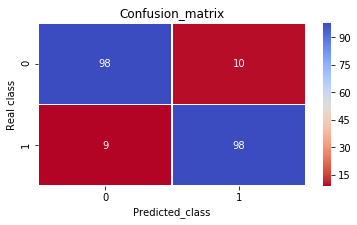


----------Classification Report------------------------------------
             precision    recall  f1-score   support

          0       0.92      0.91      0.91       108
          1       0.91      0.92      0.91       107

avg / total       0.91      0.91      0.91       215



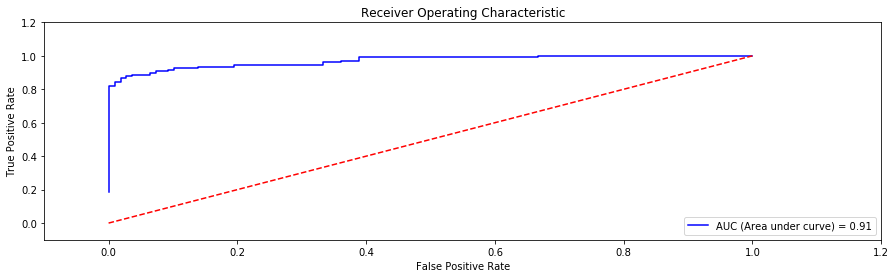

--------------------------Testing Set---------------------------
The recall for this model is: 0.940299
TP: 126
TN: 80755
FP: 4554
FN: 8


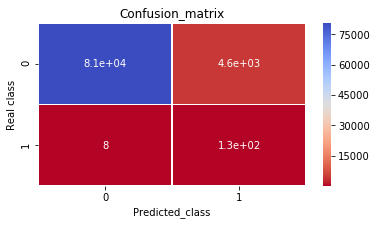


----------Classification Report------------------------------------
             precision    recall  f1-score   support

          0       1.00      0.95      0.97     85309
          1       0.03      0.94      0.05       134

avg / total       1.00      0.95      0.97     85443



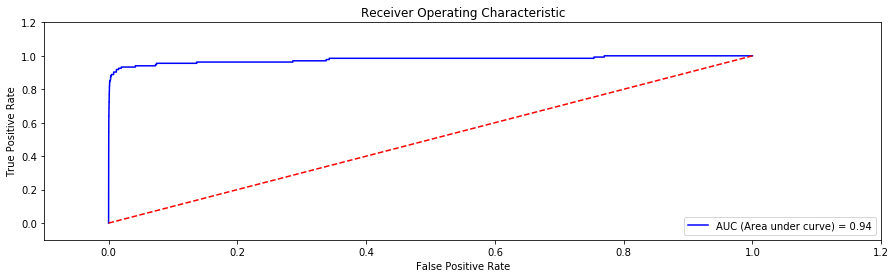

---------------------------------------------------------------


In [14]:
# Usando Logistic Regression, proporcion 1:1
apply_log_regression(1)

The undersample data for 2 proportion

The normal transacation proportion is : 0.666667
The fraud transacation proportion is : 0.333333

----------------------Validation Set------------------------

The model classification for 2 proportion

Length of training data: 751
Length of test data: 323
The recall for this model is: 0.878505
TP: 94
TN: 213
FP: 3
FN: 13


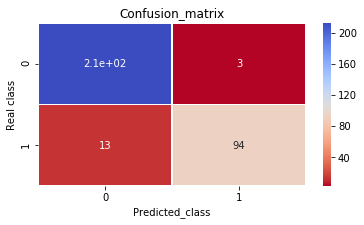


----------Classification Report------------------------------------
             precision    recall  f1-score   support

          0       0.94      0.99      0.96       216
          1       0.97      0.88      0.92       107

avg / total       0.95      0.95      0.95       323



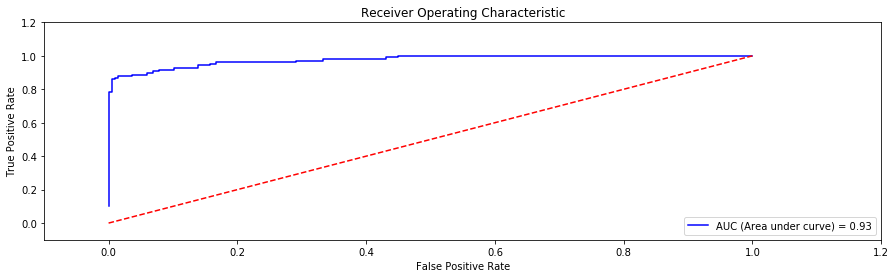

--------------------------Testing Set---------------------------
The recall for this model is: 0.925373
TP: 124
TN: 83653
FP: 1656
FN: 10


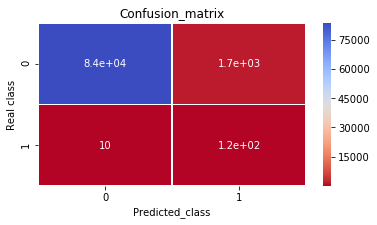


----------Classification Report------------------------------------
             precision    recall  f1-score   support

          0       1.00      0.98      0.99     85309
          1       0.07      0.93      0.13       134

avg / total       1.00      0.98      0.99     85443



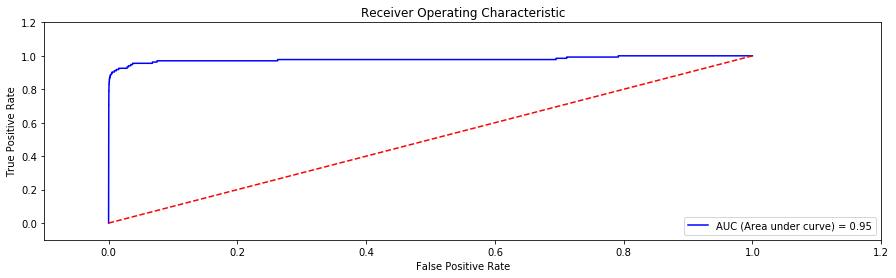

---------------------------------------------------------------


In [15]:
# Usando Logistic Regression, proporcion 2:1
apply_log_regression(2)

The undersample data for 3 proportion

The normal transacation proportion is : 0.750000
The fraud transacation proportion is : 0.250000

----------------------Validation Set------------------------

The model classification for 3 proportion

Length of training data: 1002
Length of test data: 430
The recall for this model is: 0.898990
TP: 89
TN: 325
FP: 6
FN: 10


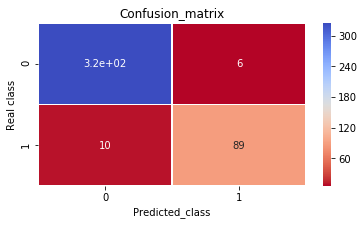


----------Classification Report------------------------------------
             precision    recall  f1-score   support

          0       0.97      0.98      0.98       331
          1       0.94      0.90      0.92        99

avg / total       0.96      0.96      0.96       430



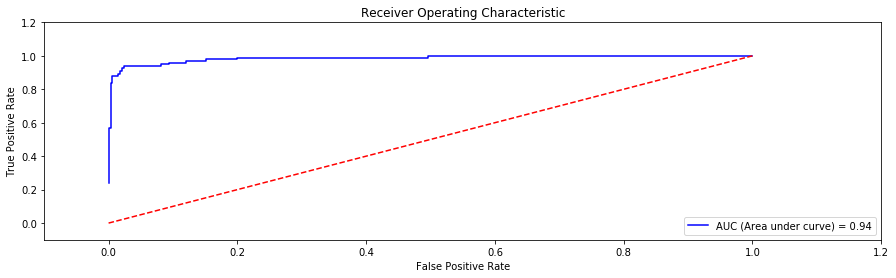

--------------------------Testing Set---------------------------
The recall for this model is: 0.925373
TP: 124
TN: 84022
FP: 1287
FN: 10


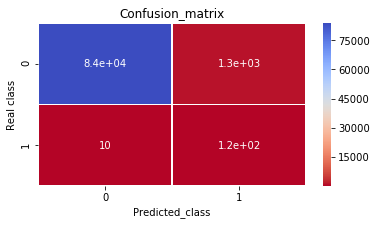


----------Classification Report------------------------------------
             precision    recall  f1-score   support

          0       1.00      0.98      0.99     85309
          1       0.09      0.93      0.16       134

avg / total       1.00      0.98      0.99     85443



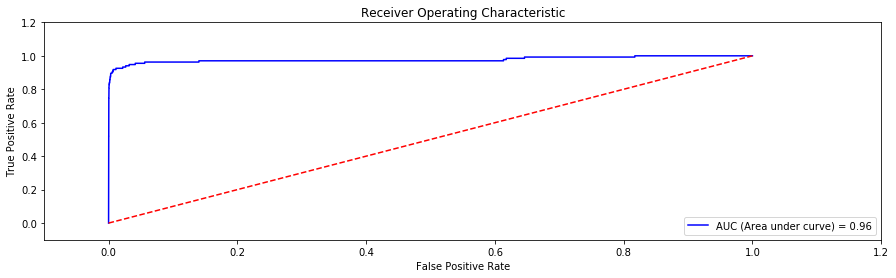

---------------------------------------------------------------


In [16]:
# Usando Logistic Regression, proporcion 3:1
apply_log_regression(3)

The undersample data for 4 proportion

The normal transacation proportion is : 0.800000
The fraud transacation proportion is : 0.200000

----------------------Validation Set------------------------

The model classification for 4 proportion

Length of training data: 1253
Length of test data: 537
The recall for this model is: 0.854167
TP: 82
TN: 438
FP: 3
FN: 14


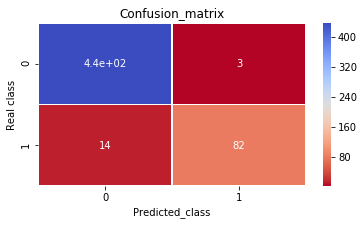


----------Classification Report------------------------------------
             precision    recall  f1-score   support

          0       0.97      0.99      0.98       441
          1       0.96      0.85      0.91        96

avg / total       0.97      0.97      0.97       537



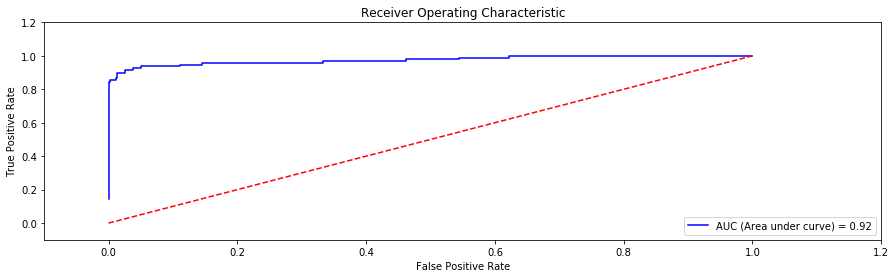

--------------------------Testing Set---------------------------
The recall for this model is: 0.902985
TP: 121
TN: 84676
FP: 633
FN: 13


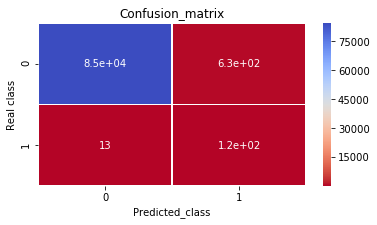


----------Classification Report------------------------------------
             precision    recall  f1-score   support

          0       1.00      0.99      1.00     85309
          1       0.16      0.90      0.27       134

avg / total       1.00      0.99      1.00     85443



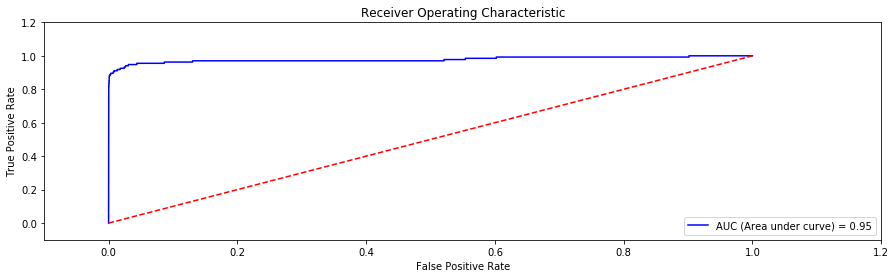

---------------------------------------------------------------


In [17]:
# Usando Logistic Regression, proporcion 4:1
apply_log_regression(4)

### Bernoulli Naive Bayes con Random Undersampling

The undersample data for 1 proportion

The normal transacation proportion is : 0.500000
The fraud transacation proportion is : 0.500000

----------------------Validation Set------------------------

The model classification for 1 proportion

Length of training data: 501
Length of test data: 215
The recall for this model is: 0.816514
TP: 89
TN: 106
FP: 0
FN: 20


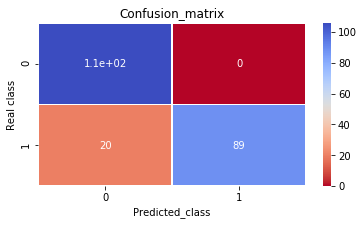


----------Classification Report------------------------------------
             precision    recall  f1-score   support

          0       0.84      1.00      0.91       106
          1       1.00      0.82      0.90       109

avg / total       0.92      0.91      0.91       215



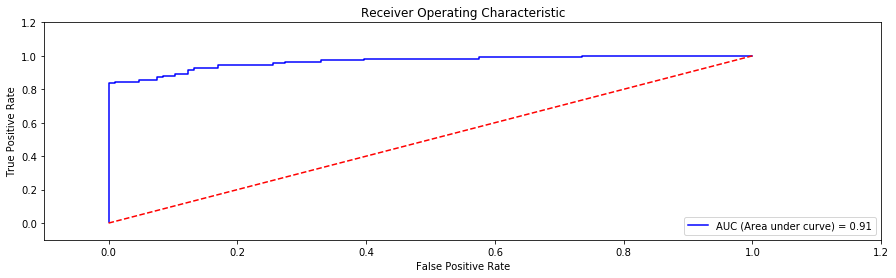

--------------------------Testing Set---------------------------
The recall for this model is: 0.843284
TP: 113
TN: 84432
FP: 877
FN: 21


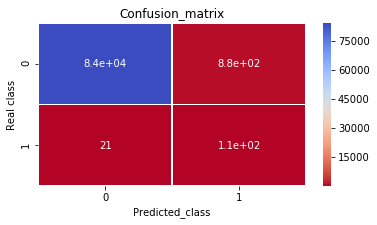


----------Classification Report------------------------------------
             precision    recall  f1-score   support

          0       1.00      0.99      0.99     85309
          1       0.11      0.84      0.20       134

avg / total       1.00      0.99      0.99     85443



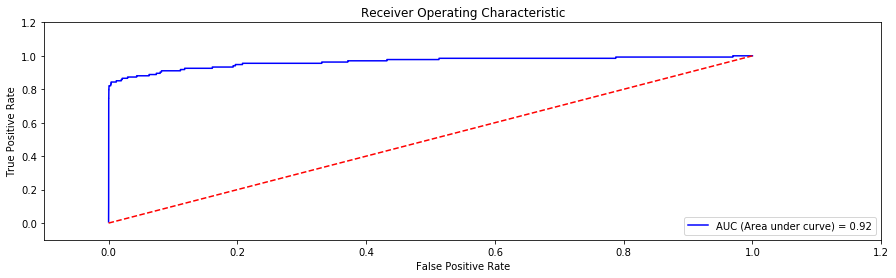

---------------------------------------------------------------


In [18]:
# BNB, razon 1:1
apply_naive_bayes(1)

The undersample data for 2 proportion

The normal transacation proportion is : 0.666667
The fraud transacation proportion is : 0.333333

----------------------Validation Set------------------------

The model classification for 2 proportion

Length of training data: 751
Length of test data: 323
The recall for this model is: 0.873786
TP: 90
TN: 217
FP: 3
FN: 13


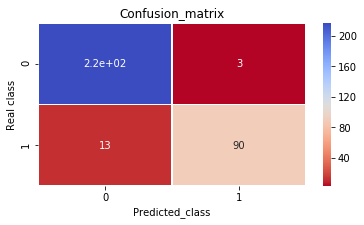


----------Classification Report------------------------------------
             precision    recall  f1-score   support

          0       0.94      0.99      0.96       220
          1       0.97      0.87      0.92       103

avg / total       0.95      0.95      0.95       323



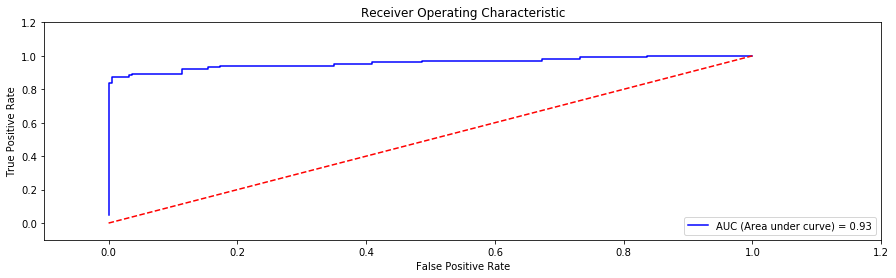

--------------------------Testing Set---------------------------
The recall for this model is: 0.843284
TP: 113
TN: 84552
FP: 757
FN: 21


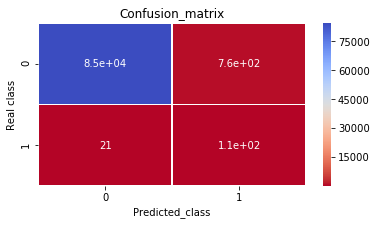


----------Classification Report------------------------------------
             precision    recall  f1-score   support

          0       1.00      0.99      1.00     85309
          1       0.13      0.84      0.23       134

avg / total       1.00      0.99      0.99     85443



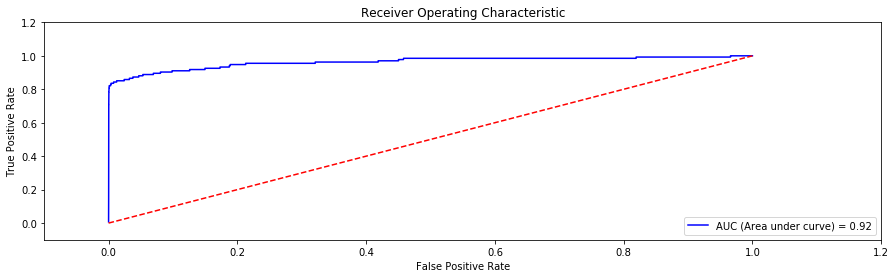

---------------------------------------------------------------


In [19]:
# BNB, razon 2:1
apply_naive_bayes(2)

The undersample data for 3 proportion

The normal transacation proportion is : 0.750000
The fraud transacation proportion is : 0.250000

----------------------Validation Set------------------------

The model classification for 3 proportion

Length of training data: 1002
Length of test data: 430
The recall for this model is: 0.790000
TP: 79
TN: 330
FP: 0
FN: 21


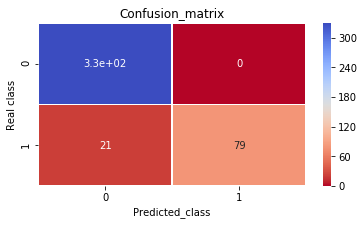


----------Classification Report------------------------------------
             precision    recall  f1-score   support

          0       0.94      1.00      0.97       330
          1       1.00      0.79      0.88       100

avg / total       0.95      0.95      0.95       430



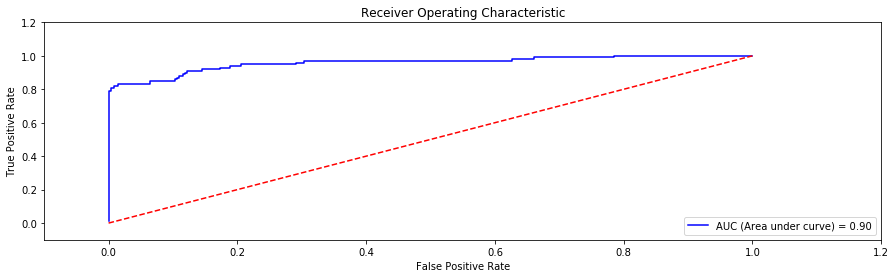

--------------------------Testing Set---------------------------
The recall for this model is: 0.828358
TP: 111
TN: 85020
FP: 289
FN: 23


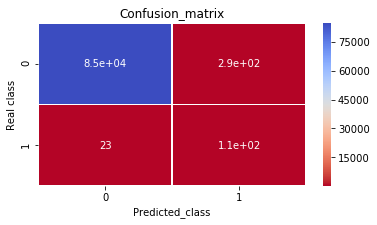


----------Classification Report------------------------------------
             precision    recall  f1-score   support

          0       1.00      1.00      1.00     85309
          1       0.28      0.83      0.42       134

avg / total       1.00      1.00      1.00     85443



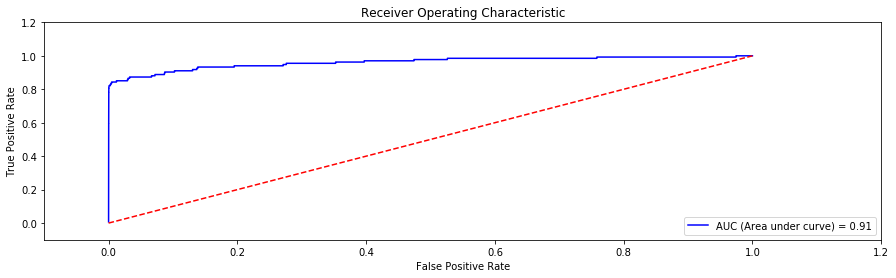

---------------------------------------------------------------


In [20]:
# BNB, razon 3:1
apply_naive_bayes(3)

The undersample data for 4 proportion

The normal transacation proportion is : 0.800000
The fraud transacation proportion is : 0.200000

----------------------Validation Set------------------------

The model classification for 4 proportion

Length of training data: 1253
Length of test data: 537
The recall for this model is: 0.803922
TP: 82
TN: 433
FP: 2
FN: 20


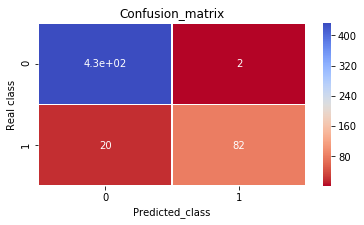


----------Classification Report------------------------------------
             precision    recall  f1-score   support

          0       0.96      1.00      0.98       435
          1       0.98      0.80      0.88       102

avg / total       0.96      0.96      0.96       537



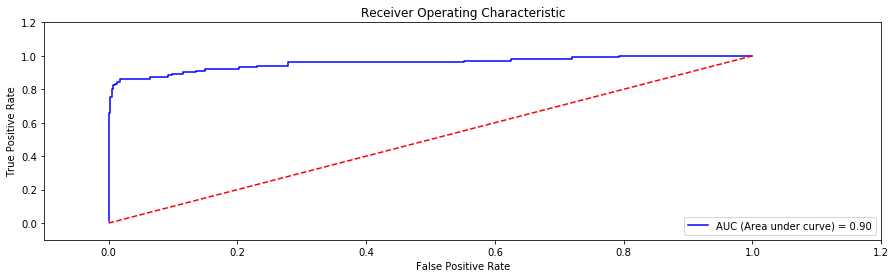

--------------------------Testing Set---------------------------
The recall for this model is: 0.835821
TP: 112
TN: 84991
FP: 318
FN: 22


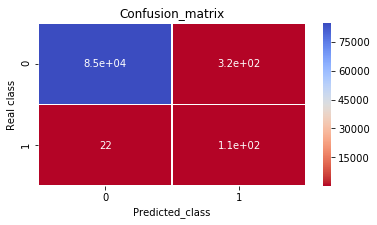


----------Classification Report------------------------------------
             precision    recall  f1-score   support

          0       1.00      1.00      1.00     85309
          1       0.26      0.84      0.40       134

avg / total       1.00      1.00      1.00     85443



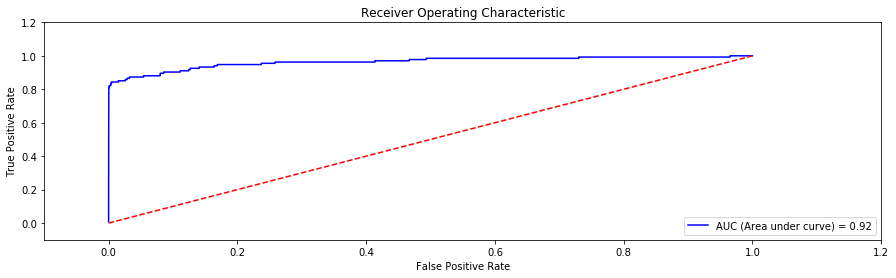

---------------------------------------------------------------


In [21]:
# BNB, razon 4:1
apply_naive_bayes(4)

## f) Comparación de modelos utilizando Oversampling y SMOTE: Logistic Regression y Bernoulli Naive Bayes

A continuación se utilizarán otras dos técnicas para balancear las clases: Oversampling y SMOTE (*Synthetic Minority Over-sampling Technique*).



In [58]:
from sklearn.metrics import roc_curve, roc_auc_score

def model(model,features_train,features_test,labels_train,labels_test):
    clf = model
    clf.fit(features_train,labels_train.values.ravel())
    pred=clf.predict(features_test)
    pred_proba = clf.predict_proba(features_test)
    cnf_matrix=confusion_matrix(labels_test,pred)
    print("The recall for this model is: %f"%(float(cnf_matrix[1,1])/(cnf_matrix[1,1]+cnf_matrix[1,0])))
    fig= plt.figure(figsize=(6,3))
    print("TP: %d"%cnf_matrix[1,1,])
    print("TN: %d"%cnf_matrix[0,0])
    print("FP: %d"%cnf_matrix[0,1])
    print("FN: %d"%cnf_matrix[1,0])
    sns.heatmap(cnf_matrix,cmap="coolwarm_r",annot=True,linewidths=0.5)
    plt.title("Confusion_matrix")
    plt.xlabel("Predicted_class")
    plt.ylabel("Real class")
    plt.show()
    print("\n----------Classification Report------------------------------------")
    print(classification_report(labels_test,pred))
    
    
    false_positive_rate, true_positive_rate, thresholds = roc_curve(labels_test,pred_proba[:,1])
    roc_auc = roc_auc_score(labels_test,pred) #hay que pasar el predict_proba en vez de pred
    plt.title('Receiver Operating Characteristic')
    plt.plot(false_positive_rate, true_positive_rate, 'b',label='AUC (Area under curve) = %0.2f'% roc_auc)
    plt.plot([0,1],[0,1],'r--')
    plt.legend(loc='lower right')
    plt.xlim([-0.1,1.2])
    plt.ylim([-0.1,1.2])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

#### Oversampling

Al contrario de *undersampling* donde se buscaba disminuír el tamaño de la clase mayoritaria, *oversampling* busca aumentar la cantidad de datos pertenecientes a la clase minoritaria, con tal de balancear el *dataset*. A continuación se presenta la funcion *oversample* la cual para lograr este balance trabaja agregando $n$ veces los datos de la clase minoritaria al *dataset* hasta lograr que la proporción de las dos clases sea aproximadamente la misma.

Las pruebas se efectuarán sólo con la proporción 1:1.

In [59]:
def oversample(data,p):
    #Se obtiene la data correspondiente a cada clase.
    fraud_data=  data[data["Class"]==1]
    normal_data = data[data["Class"]==0]
    #Se determina la cantidad de veces que se deben agregar los datos de la clase minoritaria al nuevo dataset
    times = len(normal_data)/len(fraud_data)
    #Se agregan los datos replicados n veces
    for i in range (round(times*p)):
        normal_data = normal_data.append(fraud_data)
    os_data = normal_data 
    print("Tamaño del dataset despues de hacer oversample:",len(os_data))
    print("Número de transacciones normales en el dataset balanceado:",len(os_data[os_data["Class"]==0]))
    print("Número de transacciones fraudulentas en el dataset balanceado:",len(os_data[os_data["Class"]==1]))
    print("Proporción de transacciones normales en el dataset balanceado:",len(os_data[os_data["Class"]==0])/len(os_data))
    print("proporción de transacciones fraudulentas en el dataset balanceado:",len(os_data[os_data["Class"]==1])/len(os_data))
    return(os_data)

def apply_model_os(modelo,p):
    oversample_data = oversample(x_tr,p)
    os_x,os_xt,os_yx,os_yxt=data_prepration(oversample_data)
    if modelo == 1:
        clf = BernoulliNB()
    if modelo == 2:    
        clf = LogisticRegression()
    print("\n----------------------Validation Set------------------------")
    model(clf,os_x,os_xt,os_yx,os_yxt)
    print("--------------------------Testing Set---------------------------")
    model(clf,os_x,x_ts,os_yx,y_ts)
    print("---------------------------------------------------------------")

In [60]:
x_tr,x_ts,y_tr,y_ts = data_prepration(dt)
x_tr["Class"] = y_tr["Class"]

Length of training data: 199364
Length of test data: 85443


Tamaño del dataset despues de hacer oversample: 397968
Número de transacciones normales en el dataset balanceado: 199018
Número de transacciones fraudulentas en el dataset balanceado: 198950
Proporción de transacciones normales en el dataset balanceado: 0.5000854340047441
proporción de transacciones fraudulentas en el dataset balanceado: 0.4999145659952559
Length of training data: 278577
Length of test data: 119391

----------------------Validation Set------------------------
The recall for this model is: 0.795721
TP: 47530
TN: 59132
FP: 527
FN: 12202


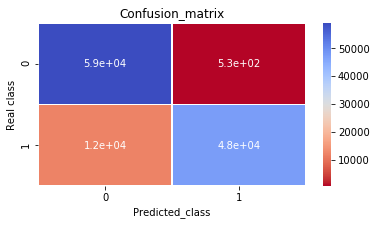


----------Classification Report------------------------------------
             precision    recall  f1-score   support

          0       0.83      0.99      0.90     59659
          1       0.99      0.80      0.88     59732

avg / total       0.91      0.89      0.89    119391



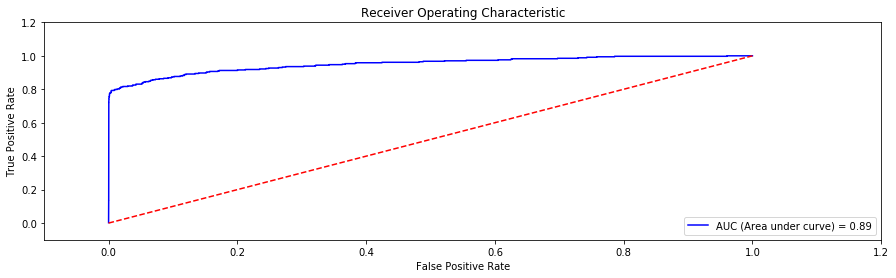

--------------------------Testing Set---------------------------
The recall for this model is: 0.863014
TP: 126
TN: 84573
FP: 724
FN: 20


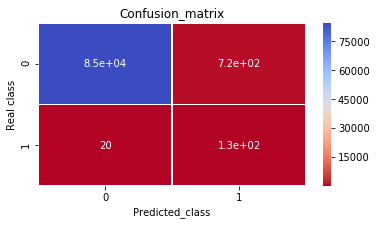


----------Classification Report------------------------------------
             precision    recall  f1-score   support

          0       1.00      0.99      1.00     85297
          1       0.15      0.86      0.25       146

avg / total       1.00      0.99      0.99     85443



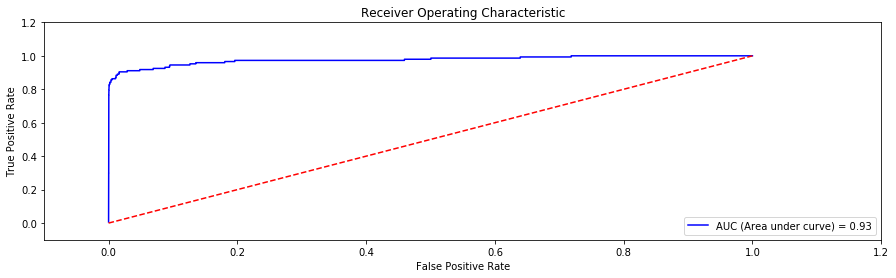

---------------------------------------------------------------


In [61]:
#Naive Bayes ~ Bernoulli, Oversampling, 1:1
apply_model_os(1,1)

Tamaño del dataset despues de hacer oversample: 397968
Número de transacciones normales en el dataset balanceado: 199018
Número de transacciones fraudulentas en el dataset balanceado: 198950
Proporción de transacciones normales en el dataset balanceado: 0.5000854340047441
proporción de transacciones fraudulentas en el dataset balanceado: 0.4999145659952559
Length of training data: 278577
Length of test data: 119391

----------------------Validation Set------------------------
The recall for this model is: 0.918768
TP: 54867
TN: 58244
FP: 1429
FN: 4851


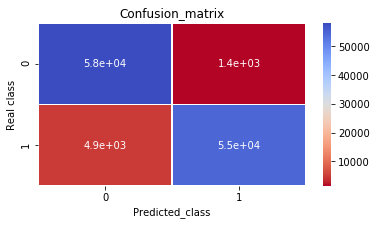


----------Classification Report------------------------------------
             precision    recall  f1-score   support

          0       0.92      0.98      0.95     59673
          1       0.97      0.92      0.95     59718

avg / total       0.95      0.95      0.95    119391



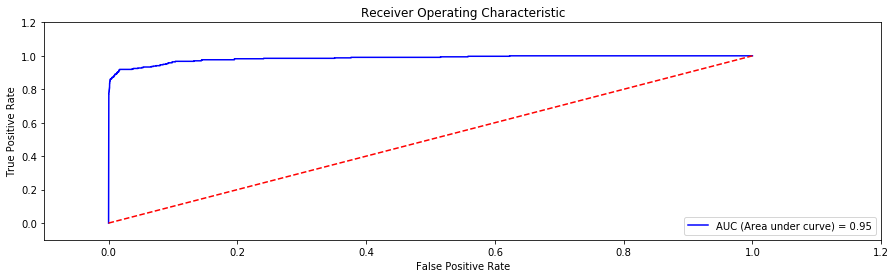

--------------------------Testing Set---------------------------
The recall for this model is: 0.931507
TP: 136
TN: 83259
FP: 2038
FN: 10


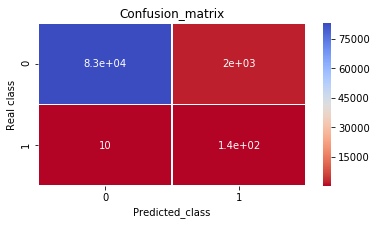


----------Classification Report------------------------------------
             precision    recall  f1-score   support

          0       1.00      0.98      0.99     85297
          1       0.06      0.93      0.12       146

avg / total       1.00      0.98      0.99     85443



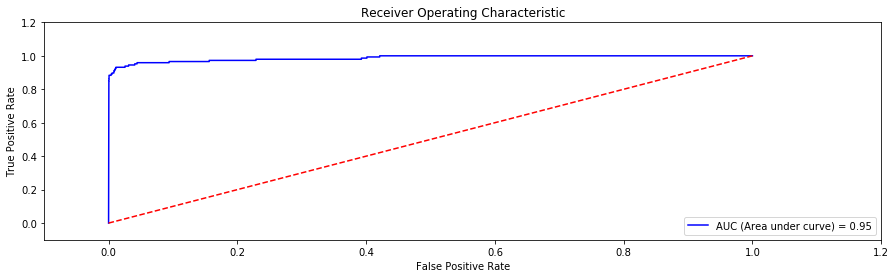

---------------------------------------------------------------


In [62]:
# Log Regression, Oversampling ,1:1
apply_model_os(2,1)

##### SMOTE

Smote es una tecnica de *oversampling* que consiste en generar de forma sintética datos correspondientes a la clase minoritaria. Este algoritmo funciona seleccionando un ejemplo de forma aleatorea de la clase minoritaria y calcula sus k vecinos mas cercanos en correspondencia con el sobremuestreo requerido para luego agregar estos nuevos datos al *dataset*. 

Cabe mencionar que no es correcto aplicar este algoritmo directamente en todo el conjunto de datos, y luego dividir los datos en el conjunto de prueba y entrenamiento, debido a que esto puede conducir a resultados engañosos, ya que existe una alta probabilidad de que los mismos datos estén presentes en el conjunto de entrenamiento e de pruebas. Debido a lo anterior es recomendable primero dividir en prueba y entrenamiento y aplicar SMOTE sobre el conjunto de datos de entrenamiento para la validación adecuada del conjunto de prueba. [Undersampling] 

La biblioteca *imbalanced-learn* tiene una implementación de SMOTE que nos será útil. Lamentablemente, esta función solía poder recibir un parámetro "ratio" en punto flotante para definir la proporción de datos en las clases, pero esta funcionalidad fue abandonada (*deprecated*) y por lo tanto, siempre se balanceará (en el caso de dos clases) en 1:1. Aunque como vimos en los ejercicios anteriores, este es la mejor razón o proporción para los modelos de clasificación, por lo que no será un problema.

In [54]:
from imblearn.over_sampling import SMOTE
os = SMOTE(random_state=15)
features_train, features_test, labels_train, labels_test = data_prepration(dt)
columns = features_train.columns

def apply_model_smote(modelo):
    os_data_X,os_data_y = os.fit_sample(features_train,labels_train['Class'])
    os_data_X = pd.DataFrame(data=os_data_X,columns=columns )
    os_data_y = pd.DataFrame(data=os_data_y,columns=["Class"])
    
    print("Tamaño de la data despues de aplicar SMOTE:",len(os_data_X))
    print("Número de transacciones normales en el dataset balanceado:",len(os_data_y[os_data_y["Class"]==0]))
    print("Número de transacciones fraudulentas en el dataset balanceado:",len(os_data_y[os_data_y["Class"]==1]))
    print("Proporción de las transacciones normales:",len(os_data_y[os_data_y["Class"]==0])/len(os_data_X))
    print("Proporción de las transacciones fraudulentas:",len(os_data_y[os_data_y["Class"]==1])/len(os_data_X))
    if modelo == 1:
        clf = BernoulliNB()
    if modelo == 2:    
        clf = LogisticRegression()
    print("\n----------------------Validation Set------------------------")
    model(clf,os_data_X,features_train,os_data_y,labels_train)
    print("\n----------------------Testing Set------------------------")
    model(clf,os_data_X,features_test,os_data_y,labels_test)
    print("---------------------------------------------------------------")

Length of training data: 199364
Length of test data: 85443


Tamaño de la data despues de aplicar SMOTE: 398046
Número de transacciones normales en el dataset balanceado: 199023
Número de transacciones fraudulentas en el dataset balanceado: 199023
Proporción de las transacciones normales: 0.5
Proporción de las transacciones fraudulentas: 0.5

----------------------Validation Set------------------------
The recall for this model is: 0.826979
TP: 282
TN: 197911
FP: 1112
FN: 59


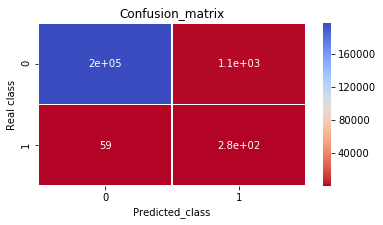


----------Classification Report------------------------------------
             precision    recall  f1-score   support

          0       1.00      0.99      1.00    199023
          1       0.20      0.83      0.33       341

avg / total       1.00      0.99      1.00    199364



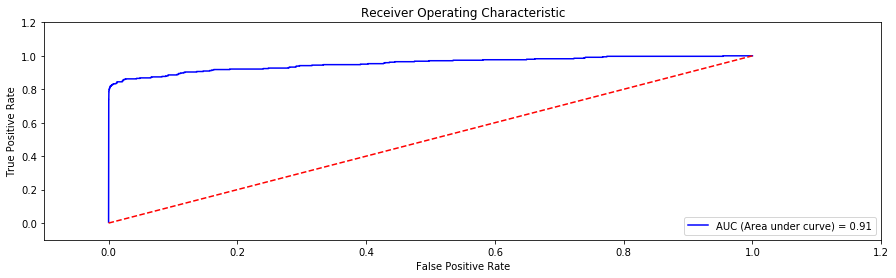


----------------------Testing Set------------------------
The recall for this model is: 0.754967
TP: 114
TN: 84845
FP: 447
FN: 37


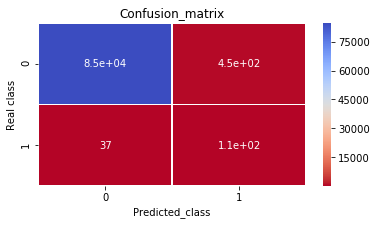


----------Classification Report------------------------------------
             precision    recall  f1-score   support

          0       1.00      0.99      1.00     85292
          1       0.20      0.75      0.32       151

avg / total       1.00      0.99      1.00     85443



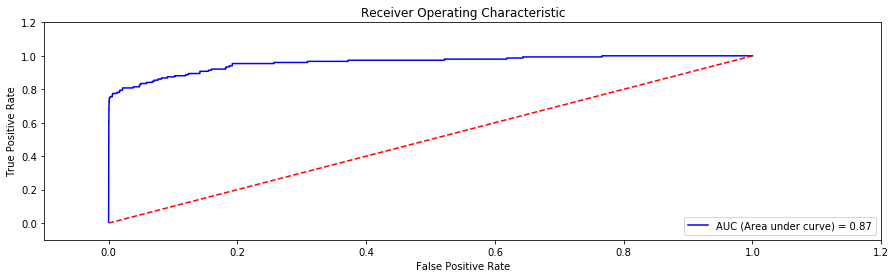

---------------------------------------------------------------


In [55]:
#Modelo naive bayes ~ bernoulli usando SMOTE en proporcion 1:1
apply_model_smote(1)

Tamaño de la data despues de aplicar SMOTE: 398046
Número de transacciones normales en el dataset balanceado: 199023
Número de transacciones fraudulentas en el dataset balanceado: 199023
Proporción de las transacciones normales: 0.5
Proporción de las transacciones fraudulentas: 0.5

----------------------Validation Set------------------------
The recall for this model is: 0.926686
TP: 316
TN: 194830
FP: 4193
FN: 25


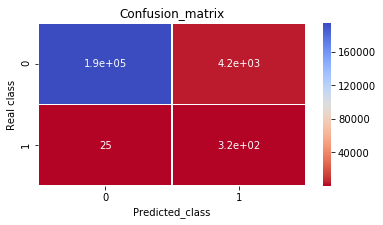


----------Classification Report------------------------------------
             precision    recall  f1-score   support

          0       1.00      0.98      0.99    199023
          1       0.07      0.93      0.13       341

avg / total       1.00      0.98      0.99    199364



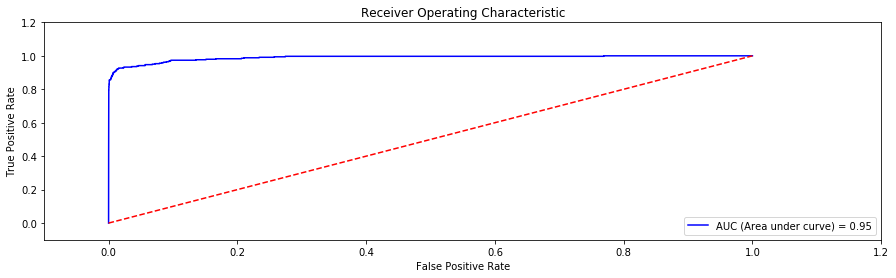


----------------------Testing Set------------------------
The recall for this model is: 0.880795
TP: 133
TN: 83563
FP: 1729
FN: 18


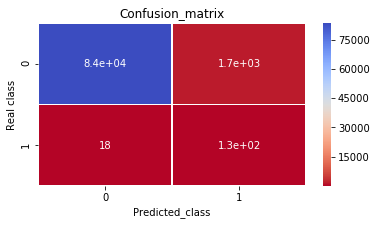


----------Classification Report------------------------------------
             precision    recall  f1-score   support

          0       1.00      0.98      0.99     85292
          1       0.07      0.88      0.13       151

avg / total       1.00      0.98      0.99     85443



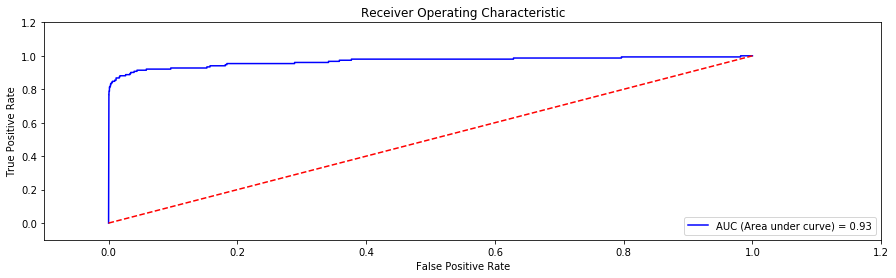

---------------------------------------------------------------


In [56]:
#Modelo Logistic regression usando SMOTE 50:50
apply_model_smote(2)

Al utilizar SMOTE nos encontramos con resultados similares al de otras técnicas de balanceo, y en este caso, Logistic Regression logra un mejor resultado que Bernoulli Naive Bayes en intentar

Finalmente se puede concluír que los problemas de clasificación con datos en clases desbalanceadas deben ser tratados con cuidado, y si bien existen técnicas para lograr un balanceo con datos "sintéticos", van a existir riesgos en el modelado final, y siempre es mejor tener las clases equitativamente balanceadas. En el caso de este problema, si bien gran parte de los datos son clasificados correctamente, existe una gran cantidad de Falsos Positivos (o sea, los modelos piensan que muchas transacciones son fraudulentas, cuando no lo son). Esto podría ser justamente ya que cada caso tiene pocos ejemplos de transacciones fraudulentas, y por tanto, se terminan creando modelos bastante simples basados en estos datos. Al utilizar técnicas como Oversampling, estos mismos pocos datos se replican, y sus características importantes van a ser consideradas aún más por los modelos.

Como tema adicional, se debe tener cuidado con métricas como la Curva ROC, ya que ésta llega a ser insuficiente para juzgar modelos como éste. La mayoría de los modelos presentados obtene buenos valores de ROC AUC, pero la cantidad de falsos positivos podría ser considerada inaceptable, según la aplicación.


# Conclusiones generales

Los algoritmos para crear modelos de clasificación son herramientas muy poderosas, pero su aplicación debe ser cuidadosa. Se deben tener en cuenta varios elementos cruciales a la hora de su uso: El sintonizado de parámetros, el uso de preprocesamiento de datos, reducción de dimensionalidad, pruebas de cross-validation y Grid Search, etc. Temas como la dimensionalidad del conjunto de datos también puede llegar a que no podamos llegar a modelos lineales con buen rendimiento, requiriendo el uso de modelos no lineales, o transformación de los datos. E incluso, puede llegar a ser un problema a la hora de aplicarse en *datasets* grandes, donde demasiadas características (como es en el caso de procesamiento de lenguaje natural) puede hacer el modelamiento infactible.


# Referencias

* [Measures] Exsilio Solutions. Accuracy, Precision, Recall & F1 Score: Interpretation of Performance Measures. Obtenido de  http://blog.exsilio.com/all/accuracy-precision-recall-f1-score-interpretation-of-performance-measures/
* [PresRecall] Scikit Learn. Precision-Recall. Obtenido de http://scikit-learn.org/stable/auto_examples/model_selection/plot_precision_recall.html
* [Porter] Stanford University. Stemming and lemmatization. Obtenido de https://nlp.stanford.edu/IR-book/html/htmledition/stemming-and-lemmatization-1.html
* [LSETrick] Cross Validated. Example of how the log-sum-exp trick works in Naive Bayes. Obtenido de https://stats.stackexchange.com/questions/105602/example-of-how-the-log-sum-exp-trick-works-in-naive-bayes
* [CParam] IBM Knowledge Center. Ajuste de un modelo SVM. Obtenido de https://www.ibm.com/support/knowledgecenter/es/SS3RA7_18.0.0/modeler_mainhelp_client_ddita/clementine/svm_perfimp.html
* [ConfMatrix] Dept. of Computer Science, University of Regina. Confusion Matrix. http://www2.cs.uregina.ca/~dbd/cs831/notes/confusion_matrix/confusion_matrix.html
* [Undersampling] S. Mishra. Handling Imbalanced Data: SMOTE vs Random Undersampling. Obtenido de https://www.irjet.net/archives/V4/i8/IRJET-V4I857.pdf